<a href="https://colab.research.google.com/github/tky5622/Advanced-Machine-Learning-with-Python/blob/master/UX%E3%83%95%E3%83%AD%E3%83%BC.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import pandas as pd
import seaborn as sns
import numpy as np 
import matplotlib.pyplot as plt
import sklearn
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from sklearn.manifold import TSNE
from sklearn.cluster import MiniBatchKMeans
import matplotlib.cm as cm

def replace_outlier(series, bias=1.5):
    #四分位数
    q1 = series.quantile(.25)
    q3 = series.quantile(.75)
    iqr = q3 - q1

    #外れ値の基準点
    outlier_min = q1 - (iqr) * bias
    outlier_max = q3 + (iqr) * bias

    print("outlier_min :" + str(outlier_min) + ", outlier_max :" + str(outlier_max))

    #外れ値をクリップする
    series = series.clip(outlier_min, outlier_max)
    return series


def readBqData(query):
  data_frame = pd.read_gbq(query, 'anx-227-stg-jp', dialect='standard')
  return data_frame

def mergeDataFrame(dataFrame1, dataFrame2):
  df_merged = dataFrame1.merge(dataFrame2, how='left', left_on="user_id", right_on="user_id").fillna(0)
  return df_merged

def mergeDataFrame(dataFrame1, dataFrame2, left_on, right_on):
  df_merged = dataFrame1.merge(dataFrame2, how='left', left_on=left_on, right_on=right_on).fillna(0)
  return df_merged


def generateMergedDataFrame(query, dataFrame):
  loadedDataFrame = readBqData(query)
  merged_dataFrame = mergeDataFrame(dataFrame, loadedDataFrame)
  return merged_dataFrame

def getMonthData(day_count, getDataFrameFunc):
  oldDataFrame = 0

  for index in range(day_count):
    i = index + 1
    dateString = str(i)
    if i < 10:
       dateString = "0" + str(i)

    df_data = getDataFrameFunc(dateString)
    df_data.rename(columns = lambda x: x + '_' + str(i) if x != 'user_id' else x, inplace=True)

    if i > 1:
      oldDataFrame = pd.merge(oldDataFrame, df_data, on="user_id", how='outer')
      oldDataFrame = oldDataFrame.fillna(0) 
    elif i == 1:
      oldDataFrame = df_data.fillna(0) 
  
  return oldDataFrame

def showHistogram(query):
  sns.distplot(
    query, bins=50, color='#123456', label='data', norm_hist=True,
    kde=False,
    rug=False
  )
  return plt.show()

#=======================機械学習系======================#

def getFilterdGroup(df, group):
    df_filtered=df[df[group]==1]
    return df_filtered

def showGroupDescribe(df, group):
    df_filtered=df[df[group]==1]
    return df_filtered.describe()

def getPCA(df):
  pca = PCA()
  pca.fit(df)
  return pca

def showCCratio(pca, df):

  values = pca.transform(df)
  df_pca=pd.DataFrame(data = values, columns = ["主成分{}".format(x+1) for x in range(len(df.columns))])
  # モデルpcaの寄与率を算出
  ev_ratio = pca.explained_variance_ratio_

  # 寄与率をデータフレームに変換
  df_evr = pd.DataFrame(data = ev_ratio, 
                      columns = ['寄与率'],
                      index = ["主成分{}".format(x+1) for x in range(len(df.columns))])

  # 寄与率を累積する
  cc_ratio = np.cumsum(ev_ratio)

  # 0を連結
  cc_ratio = np.hstack([0, cc_ratio])

  # グラフを描画
  plt.plot(cc_ratio, "-o")
  plt.xlabel("主成分")
  plt.ylabel("累積寄与率")
  plt.grid()
  return  plt.show()

def getPcaDataFrame(pca, df):
  eigen_value = pca.explained_variance_
  pd.DataFrame(eigen_value, 
             columns = ["分散"], 
             index = ["主成分{}".format(x+1) for x in range(len(df.columns))])

  # 主成分負荷量を算出
  eigen_vector = pca.components_
  # データフレームに変換
  return pd.DataFrame(eigen_vector,
             columns = [df.columns],
             index = ["主成分{}".format(x+1) for x in range(len(df.columns))])

def getTSNEDataFrameEmbedded(df):
  df.reset_index(drop=True, inplace=True)
  tsne = TSNE(n_components=2, random_state = 0, perplexity = 30, n_iter = 1000)
  return tsne.fit_transform(df)


def showTSNEresult(df_embedded, evaluation_column): 
  evaluation_column.reset_index(drop=True, inplace=True)
  plt.scatter(df_embedded[:, 0], df_embedded[:, 1], c=evaluation_column)
  return plt.colorbar()

def getKmeansTSNE(df_embedded, cluster_num):
  # クラスタの数`n_clusters`はTSNEのグラフを見て、感覚で決めた
  #random_stateを指定しないと実行するたびにグループ番号が変わってしまう
  kmeans = MiniBatchKMeans(n_clusters=cluster_num, max_iter=1000, random_state=1)
  return kmeans.fit_predict(df_embedded)

def showTSNEClustering(df_embedded, kmeans_tsne):
  #いい感じに色を付ける
  color=cm.brg(np.linspace(0,1,np.max(kmeans_tsne) - np.min(kmeans_tsne)+1))
  for i in range(np.min(kmeans_tsne), np.max(kmeans_tsne)+1):
    plt.plot(df_embedded[kmeans_tsne == i][:,0],
             df_embedded[kmeans_tsne == i][:,1],
             ".",
             color=color[i]
             )
    plt.text(df_embedded[kmeans_tsne == i][:,0][0],
             df_embedded[kmeans_tsne == i][:,1][0],
             str(i), color="black", size=16
             )
  return plt.show()

def getGroupedDataFrame(kmeans_tsne, df_original):
  df_kmeans_tsne = pd.DataFrame(kmeans_tsne)
  #元データとくっつける
  df_result=df_kmeans_tsne.join(df_original)
  #カラム名を変更
  df_result.rename(columns={0: 'group'}, inplace=True)
  df_result_group=pd.get_dummies(df_result['group'], prefix='group')
  return df_result_group.join(df_result)

def joinResetIndex(df1, df2):
  df1.reset_index(drop=True, inplace=True)
  df2.reset_index(drop=True, inplace=True)
  return df1.join(df2)

def joinResetIndes(df1, *df2):
  df1.reset_index(drop=True, inplace=True)
  df2.reset_index(drop=True, inplace=True)
  return df1.join(df2)


def countMatchingValue(df, key, value):
  df=df[key]==value
  return df.sum()

In [ ]:
def dfDropColumn(df, dropColumnArray):
  #df_dropped=df.drop(['Unnamed: 0', 'user_id', 'Unnamed: 0_y', 'Unnamed: 0_x','use_charge_gem_count_sum','normal_music_count','event_music_count','cover_music_count','original_music_count','this_event_music_count','live_flg','easy_success_count','normal_success_count','hard_success_count','expert_success_count','not_received_mission_reward_count','receive_mission_reward_count','daily_mission_count','weekly_mission_count','beginner_mission_count','twitter_follow_count','line_follow_count','mission_progress_sum','first_fraud_flg','first_live_master_point','first_easy_success_flg','first_normal_success_flg','first_hard_success_flg','first_expert_success_flg','first_easy_retire_flg','first_normal_retire_flg','first_hard_retire_flg','first_expert_retire_flg','first_solo_flg','card_exp_avg','get_item_type_practice_ticket_sum','get_item_type_skill_practice_ticket_sum','card_exp_sum_flg','card_exp_avg_flg'], axis=1)
  df_dropped=df.drop(['user_id', 'Unnamed: 0', 'creation_day'], axis=1)
  return df_dropped.drop(dropColumnArray, axis=1)



In [ ]:
##getDummiesをjoinする関数
def joinDummies(origin_df, df_column, prefix):
  ### getDummiesする
  df_dummies=pd.get_dummies(df_column, prefix=prefix)
  ### joinする
  return joinResetIndex(df_dummies, origin_df)

In [ ]:
def getUXflowDataFrame(game_start_date, aggregate_start_date, aggregate_end_date, target_event_id, new_user_flg):
  if(new_user_flg):
    new_user_condiction=''
    pick_user_condiction=''
  else:
    new_user_condiction='NOT'
    pick_user_condiction="AND SUBSTR(CAST( fq_table.user_id AS string), 12, 1) ='5'"

  query="""
DECLARE game_start_date STRING DEFAULT '{0}';
DECLARE aggregate_start_date STRING DEFAULT '{1}';
DECLARE aggregate_end_date STRING DEFAULT '{2}';
DECLARE target_event_id INT64 DEFAULT {3};

#DECLARE game_start_date STRING DEFAULT '2020-07-31'; #面倒なので変えた
#DECLARE aggregate_start_date STRING DEFAULT '2020-07-31';
#DECLARE aggregate_end_date STRING DEFAULT '2020-08-01';
#DECLARE target_event_id INT64 DEFAULT 20000300;
#DECLARE aggregate_start_date STRING DEFAULT '2020-08-18';
#DECLARE aggregate_end_date STRING DEFAULT '2020-08-24';
#DECLARE target_event_id INT64 DEFAULT 20000400;
DECLARE target_event_point INT64 DEFAULT 500000;
#イベントカード 10740002, 10340003, 10640003, 10440002

WITH user_profile AS (
SELECT
  latest_data1.id,
  latest_data1.name,
  exp,
  vip_point,
  favorite_master_card_id,
  c.name AS favorite_master_card_name,
  favorite_card_evolve,
  master_title_ids,
  t.name AS master_title_name,
  profile_settings,
  setting_trophy_grade_id,
  master_trophy_grade_id,
  total_master_trophy_detail_point,
  FORMAT_DATE('%Y-%m-%d', DATE(created_at, 'Asia/Tokyo')) AS creation_day
FROM
  (    
    SELECT
        ROW_NUMBER() OVER (
            PARTITION BY
                id
            ORDER BY
                FORMAT_DATE('%Y-%m-%d', DATE(updated_at, 'Asia/Tokyo')) DESC
        ) AS latest_id1,
        *
    FROM
        `anx-227-stg-jp.rds_snapshot_data.prddb10user_prd_tts_user_bq_*` AS u
    ) AS latest_data1
LEFT JOIN
  `master.card` AS c
ON CAST(latest_data1.favorite_master_card_id AS STRING)=c.id
LEFT JOIN
  `master.title` AS t
ON latest_data1.master_title_ids=CONCAT('[' , t.id, ']')
WHERE latest_data1.latest_id1=1 AND FORMAT_DATE('%Y-%m-%d', DATE(created_at, 'Asia/Tokyo')) {4} BETWEEN aggregate_start_date AND aggregate_end_date
GROUP BY id,name,exp,vip_point,favorite_master_card_id,favorite_card_evolve,master_title_ids,t.name,c.name,profile_settings,setting_trophy_grade_id,master_trophy_grade_id,total_master_trophy_detail_point,creation_day
UNION ALL
SELECT
  latest_data2.id,
  latest_data2.name,
  exp,
  vip_point,
  favorite_master_card_id,
  c.name AS favorite_master_card_name,
  favorite_card_evolve,
  master_title_ids,
  t.name AS master_title_name,
  profile_settings,
  setting_trophy_grade_id,
  master_trophy_grade_id,
  total_master_trophy_detail_point,
  FORMAT_DATE('%Y-%m-%d', DATE(created_at, 'Asia/Tokyo')) AS creation_day
FROM
  (    
    SELECT
        ROW_NUMBER() OVER (
            PARTITION BY
                id
            ORDER BY
                FORMAT_DATE('%Y-%m-%d', DATE(updated_at, 'Asia/Tokyo')) DESC
        ) AS latest_id2,
        *
    FROM
        `anx-227-stg-jp.rds_snapshot_data.prddb11user_prd_tts_user_bq_*` AS u
    ) AS latest_data2
LEFT JOIN
  `master.card` AS c
ON CAST(latest_data2.favorite_master_card_id AS STRING)=c.id
LEFT JOIN
  `master.title` AS t
ON latest_data2.master_title_ids=CONCAT('[' , t.id, ']')
WHERE latest_data2.latest_id2=1 AND FORMAT_DATE('%Y-%m-%d', DATE(created_at, 'Asia/Tokyo')) {4} BETWEEN aggregate_start_date AND aggregate_end_date
GROUP BY id,name,exp,vip_point,favorite_master_card_id,favorite_card_evolve,master_title_ids,t.name,c.name,profile_settings,setting_trophy_grade_id,master_trophy_grade_id,total_master_trophy_detail_point,creation_day
UNION ALL
SELECT
  latest_data3.id,
  latest_data3.name,
  exp,
  vip_point,
  favorite_master_card_id,
  c.name AS favorite_master_card_name,
  favorite_card_evolve,
  master_title_ids,
  t.name AS master_title_name,
  profile_settings,
  setting_trophy_grade_id,
  master_trophy_grade_id,
  total_master_trophy_detail_point,
  FORMAT_DATE('%Y-%m-%d', DATE(created_at, 'Asia/Tokyo')) AS creation_day
FROM
  (    
    SELECT
        ROW_NUMBER() OVER (
            PARTITION BY
                id
            ORDER BY
                FORMAT_DATE('%Y-%m-%d', DATE(updated_at, 'Asia/Tokyo')) DESC
        ) AS latest_id3,
        *
    FROM
        `anx-227-stg-jp.rds_snapshot_data.prddb12user_prd_tts_user_bq_*` AS u
    ) AS latest_data3
LEFT JOIN
  `master.card` AS c
ON CAST(latest_data3.favorite_master_card_id AS STRING)=c.id
LEFT JOIN
  `master.title` AS t
ON latest_data3.master_title_ids=CONCAT('[' , t.id, ']')
WHERE latest_data3.latest_id3=1 AND FORMAT_DATE('%Y-%m-%d', DATE(created_at, 'Asia/Tokyo')) {4} BETWEEN aggregate_start_date AND aggregate_end_date
GROUP BY id,name,exp,vip_point,favorite_master_card_id,favorite_card_evolve,master_title_ids,t.name,c.name,profile_settings,setting_trophy_grade_id,master_trophy_grade_id,total_master_trophy_detail_point,creation_day
UNION ALL
SELECT
  latest_data4.id,
  latest_data4.name,
  exp,
  vip_point,
  favorite_master_card_id,
  c.name AS favorite_master_card_name,
  favorite_card_evolve,
  master_title_ids,
  t.name AS master_title_name,
  profile_settings,
  setting_trophy_grade_id,
  master_trophy_grade_id,
  total_master_trophy_detail_point,
  FORMAT_DATE('%Y-%m-%d', DATE(created_at, 'Asia/Tokyo')) AS creation_day
FROM
  (    
    SELECT
        ROW_NUMBER() OVER (
            PARTITION BY
                id
            ORDER BY
                FORMAT_DATE('%Y-%m-%d', DATE(updated_at, 'Asia/Tokyo')) DESC
        ) AS latest_id4,
        *
    FROM
        `anx-227-stg-jp.rds_snapshot_data.prddb13user_prd_tts_user_bq_*` AS u
    ) AS latest_data4
LEFT JOIN
  `master.card` AS c
ON CAST(latest_data4.favorite_master_card_id AS STRING)=c.id
LEFT JOIN
  `master.title` AS t
ON latest_data4.master_title_ids=CONCAT('[' , t.id, ']')
WHERE latest_data4.latest_id4=1 AND FORMAT_DATE('%Y-%m-%d', DATE(created_at, 'Asia/Tokyo')) {4} BETWEEN aggregate_start_date AND aggregate_end_date
GROUP BY id,name,exp,vip_point,favorite_master_card_id,favorite_card_evolve,master_title_ids,t.name,c.name,profile_settings,setting_trophy_grade_id,master_trophy_grade_id,total_master_trophy_detail_point,creation_day
),

except_bot_user_id AS (
  SELECT
    fq_table.user_id,
    exp,
    favorite_master_card_id,
    c.master_character_id,
    --master_title_ids,
    ARRAY_LENGTH(SPLIT(profile_settings, ',')) AS profile_setting_count,
    creation_day
  FROM
    `rds_kpi_data.prddb50kpi_prd_tts_kpi_kpi_fq5_bq` AS fq_table
  LEFT JOIN
    `rds_kpi_data.prddb50kpi_prd_tts_kpi_bot_user_id_bq` AS bot_table
  ON
    fq_table.user_id = bot_table.user_id
  LEFT JOIN
    user_profile AS u
  ON fq_table.user_id=u.id
  LEFT JOIN
    `master.card` AS c
 ON CAST(u.favorite_master_card_id AS STRING)=c.id
  WHERE
    #created_atにしても新規にはならない userテーブルの結合の必要あり
    aggregate_date BETWEEN aggregate_start_date AND aggregate_end_date
    AND creation_day {4} BETWEEN aggregate_start_date AND aggregate_end_date
    AND login_flg=1
    AND bot_table.user_id IS NULL
    -- 既存の場合量が多く、固定のランダム値にするため、下2桁が5の値を抽出
    {5}
  GROUP BY
    fq_table.user_id,
    exp,
    favorite_master_card_id,
    c.master_character_id,
    --master_title_ids,
    profile_setting_count,
    creation_day
),

/**
  ☆4カードデータ
**/
play_card_data AS (
SELECT
    user_id,
    l.deck_main_master_card_id_1,
    l.deck_main_master_card_id_2,
    l.deck_main_master_card_id_3,
    l.deck_main_master_card_id_4,
    l.deck_main_master_card_id_5,
    ## bigqueryでは列名重複はNG
    c1.rarity AS rarity_card1,
    c2.rarity AS rarity_card2,
    c3.rarity AS rarity_card3,
    c4.rarity AS rarity_card4,
    c5.rarity AS rarity_card5,
    start_date
FROM
  `anx-227-stg-jp.rds_kpi_data.prddb50kpi_prd_tts_kpi_live_log_bq`  AS l
LEFT JOIN
  `anx-227-stg-jp.master.card`  AS c1
ON CAST(l.deck_main_master_card_id_1 AS STRING)=c1.id 
LEFT JOIN
  `anx-227-stg-jp.master.card`  AS c2
ON CAST(l.deck_main_master_card_id_2 AS STRING)=c2.id
LEFT JOIN
  `anx-227-stg-jp.master.card`  AS c3
ON CAST(l.deck_main_master_card_id_3 AS STRING)=c3.id 
LEFT JOIN
  `anx-227-stg-jp.master.card`  AS c4
ON CAST(l.deck_main_master_card_id_4 AS STRING)=c4.id 
LEFT JOIN
  `anx-227-stg-jp.master.card`  AS c5
ON CAST(l.deck_main_master_card_id_5 AS STRING)=c5.id 
WHERE
  FORMAT_DATE('%Y-%m-%d', DATE(start_date)) BETWEEN aggregate_start_date AND aggregate_end_date
GROUP BY
  user_id,c1.rarity,c2.rarity,c3.rarity,c4.rarity,c5.rarity,deck_main_master_card_id_1,deck_main_master_card_id_2,deck_main_master_card_id_3,deck_main_master_card_id_4,deck_main_master_card_id_5,start_date
),

rare4card_count AS (
SELECT
   user_id,
   CASE WHEN (CASE WHEN rarity_card1='RARE4' THEN 1 ELSE 0 END + 
   CASE WHEN rarity_card2='RARE4' THEN 1 ELSE 0 END +
   CASE WHEN rarity_card3='RARE4' THEN 1 ELSE 0 END +
   CASE WHEN rarity_card4='RARE4' THEN 1 ELSE 0 END +
   CASE WHEN rarity_card5='RARE4' THEN 1 ELSE 0 END)>0 THEN 1 ELSE 0 END  AS rarity4_flg,
FROM
(
  SELECT
        ROW_NUMBER() OVER (
            PARTITION BY
                user_id
            ORDER BY
                 start_date DESC
        ) AS latest_id,
        *
   FROM
        play_card_data
) AS latest_card_data
WHERE latest_card_data.latest_id=1
GROUP BY user_id,rarity_card1,rarity_card2,rarity_card3,rarity_card4,rarity_card5
),

special_event_card_count AS (
SELECT
   user_id,
   CASE WHEN (CASE WHEN deck_main_master_card_id_1 IN (10740002, 10340003, 10640003, 10440002) THEN 1 ELSE 0 END + 
   CASE WHEN deck_main_master_card_id_2 IN (10740002, 10340003, 10640003, 10440002) THEN 1 ELSE 0 END + 
   CASE WHEN deck_main_master_card_id_3 IN (10740002, 10340003, 10640003, 10440002) THEN 1 ELSE 0 END + 
   CASE WHEN deck_main_master_card_id_4 IN (10740002, 10340003, 10640003, 10440002) THEN 1 ELSE 0 END + 
   CASE WHEN deck_main_master_card_id_5 IN (10740002, 10340003, 10640003, 10440002) THEN 1 ELSE 0 END) >0 THEN 1 ELSE 0 END AS special_event_card_flg
FROM
(
  SELECT
        ROW_NUMBER() OVER (
            PARTITION BY
                user_id
            ORDER BY
                 start_date DESC
        ) AS latest_id,
        *
   FROM
        play_card_data
) AS latest_card_data
WHERE latest_card_data.latest_id=1
GROUP BY user_id,deck_main_master_card_id_1,deck_main_master_card_id_2,deck_main_master_card_id_3,deck_main_master_card_id_4,deck_main_master_card_id_5
),


/**
  初回ライブデータ
**/
first_live_data AS (
SELECT
  user_id,
  CASE WHEN live_status='SUCCESS' THEN 1 ELSE 0 END AS first_success_flg,
  CASE WHEN live_status='RETIRE' THEN 1 ELSE 0 END AS first_retire_flg,
  ll.integer_level_number AS first_true_level,
  CASE WHEN (perfect+great+good+bad+miss) !=0 THEN (bad+miss)/(perfect+great+good+bad+miss) ELSE 0 END AS first_bad_miss_rate,
  perfect*5+great*4+good*3+bad*2+miss*1 AS first_live_master_point,
  CASE WHEN live_production_type=1 THEN 1 ELSE 0 END AS first_threed_live_flg,
  -- 難易度別プレイ回数x成功
  CASE WHEN l.level=1 AND live_status='SUCCESS' THEN 1 ELSE 0 END AS first_easy_success_flg,
  CASE WHEN l.level=2 AND live_status='SUCCESS' THEN 1 ELSE 0 END AS first_normal_success_flg,
  CASE WHEN l.level=3 AND live_status='SUCCESS' THEN 1 ELSE 0 END AS first_hard_success_flg,
  CASE WHEN l.level=4 AND live_status='SUCCESS' THEN 1 ELSE 0 END AS first_expert_success_flg,
  -- 難易度別プレイ回数x失敗
  CASE WHEN l.level=1 AND live_status='RETIRE' THEN 1 ELSE 0 END AS first_easy_retire_flg,
  CASE WHEN l.level=2 AND live_status='RETIRE' THEN 1 ELSE 0 END AS first_normal_retire_flg,
  CASE WHEN l.level=3 AND live_status='RETIRE' THEN 1 ELSE 0 END AS first_hard_retire_flg,
  CASE WHEN l.level=4 AND live_status='RETIRE' THEN 1 ELSE 0 END AS first_expert_retire_flg,
  CASE WHEN live_status='FRAUD' THEN 1 ELSE 0 END AS first_fraud_flg,
  CASE WHEN live_status='START' THEN 1 ELSE 0 END AS first_start_flg,
  CASE WHEN live_mode=1 THEN 1 ELSE 0 END AS first_solo_flg,
  CASE WHEN music_type='NORMAL' THEN 1 ELSE 0 END  AS first_normal_music_flg,
  CASE WHEN m.category='COVER' THEN 1 ELSE 0 END AS first_cover_music_count,
FROM
(
  SELECT
        ROW_NUMBER() OVER (
            PARTITION BY
                user_id
            ORDER BY
                start_date ASC
        ) AS oldest_id,
        *
   FROM
       `anx-227-stg-jp.rds_kpi_data.prddb50kpi_prd_tts_kpi_live_log_bq`
   WHERE
      FORMAT_DATE('%Y-%m-%d', DATE(start_date)) BETWEEN game_start_date AND aggregate_end_date
) AS l
LEFT JOIN
  `anx-227-stg-jp.master.live_level` AS ll
ON CAST(l.master_live_id AS STRING)=ll.master_live_id
LEFT JOIN
  `anx-227-stg-jp.master.live` AS li
ON CAST(l.master_live_id AS STRING)=li.id
LEFT JOIN
  `anx-227-stg-jp.master.music` AS m
ON CAST(l.master_live_id AS STRING)=m.id
WHERE l.oldest_id=1 
GROUP BY
  user_id,ll.integer_level_number,l.level,live_status,live_mode,music_type,m.category,live_production_type,first_bad_miss_rate,first_live_master_point
),

/**
  ライブデータ
**/
live_data AS (
SELECT
  user_id,
  CASE WHEN SUM(CASE WHEN live_status='SUCCESS' THEN 1 ELSE 0 END) > 0 THEN 1 ELSE 0 END AS success_flg,
  CASE WHEN SUM(CASE WHEN live_status='RETIRE' THEN 1 ELSE 0 END) > 0 THEN 1 ELSE 0 END AS retire_flg,
  SUM(CASE WHEN live_status='SUCCESS' THEN 1 ELSE 0 END) AS success_sum,
  SUM(CASE WHEN live_status='RETIRE' THEN 1 ELSE 0 END) AS retire_sum,
  AVG(l.level) AS level_avg,
  AVG(ll.integer_level_number) AS true_level_avg,
  SUM(is_all_perfect)/count(*) AS is_all_perfect_avg,
  SUM(is_full_combo)/count(*) AS is_full_combo_avg,
  AVG(CASE WHEN (perfect+great+good+bad+miss)!=0 THEN bad+miss/(perfect+great+good+bad+miss) ELSE 0 END) AS bad_miss_rate_avg,
  AVG(perfect*5+great*4+good*3+bad*2+miss*1) AS live_master_point,
  AVG(theoretical_score) AS theoretical_score_avg,
  AVG(raw_score) AS raw_score_avg,
  -- 実得点/最高得点=達成度
  AVG(raw_score/li.score_ss) AS live_score_rate_compare_ss,
  count(DISTINCT live_unique_id) AS live_count,
  CASE WHEN count(DISTINCT live_unique_id)>0 THEN 1 ELSE 0 END AS live_flg,
  count(DISTINCT l.master_live_id) AS live_music_kind_count,
  SUM(CASE WHEN live_production_type=1 THEN 1 ELSE 0 END) AS threed_live_sum,
  -- 難易度別プレイ回数
  SUM(CASE WHEN l.level=1 THEN 1 ELSE 0 END) AS easy_count,
  SUM(CASE WHEN l.level=2 THEN 1 ELSE 0 END) AS normal_count,
  SUM(CASE WHEN l.level=3 THEN 1 ELSE 0 END) AS hard_count,
  SUM(CASE WHEN l.level=4 THEN 1 ELSE 0 END) AS expert_count,
  SUM(CASE WHEN l.level=5 THEN 1 ELSE 0 END) AS pro_count,
  -- 難易度別プレイ回数x成功
  SUM(CASE WHEN l.level=1 AND live_status='SUCCESS' THEN 1 ELSE 0 END) AS easy_success_count,
  SUM(CASE WHEN l.level=2 AND live_status='SUCCESS' THEN 1 ELSE 0 END) AS normal_success_count,
  SUM(CASE WHEN l.level=3 AND live_status='SUCCESS' THEN 1 ELSE 0 END) AS hard_success_count,
  SUM(CASE WHEN l.level=4 AND live_status='SUCCESS' THEN 1 ELSE 0 END) AS expert_success_count,
  SUM(CASE WHEN l.level=5 AND live_status='SUCCESS' THEN 1 ELSE 0 END) AS pro_success_count,
  -- ソロの場合 
    /*
  AVG(CASE WHEN live_mode=1
  THEN CASE WHEN score < li.score_c THEN 1 
  WHEN score < li.score_b THEN 2 
  WHEN score < li.score_a THEN 3  
  WHEN score < li.score_s THEN 4  
  WHEN score < li.score_ss THEN 5 
  WHEN score >= li.score_ss THEN 6 END END) AS solo_live_score_level_avg,
  SUM(CASE WHEN live_mode=1 THEN CASE WHEN score < li.score_c THEN 1 ELSE 0 END END) AS solo_score_c_count,
  SUM(CASE WHEN live_mode=1 THEN CASE WHEN score < li.score_b THEN 1 ELSE 0 END END) AS solo_score_b_count,
  SUM(CASE WHEN live_mode=1 THEN CASE WHEN score < li.score_a THEN 1 ELSE 0 END END) AS solo_score_a_count,
  SUM(CASE WHEN live_mode=1 THEN CASE WHEN score < li.score_s THEN 1 ELSE 0 END END) AS solo_score_s_count,
  SUM(CASE WHEN live_mode=1 THEN CASE WHEN score < li.score_ss THEN 1 ELSE 0 END END) AS solo_score_ss_count,
  SUM(CASE WHEN live_mode=1 THEN CASE WHEN score >= li.score_ss THEN 1 ELSE 0 END END) AS solo_score_over_ss_count,
  
  AVG(CASE WHEN live_mode!=1 AND live_mode!=0
  THEN CASE WHEN score < li.multi_score_c THEN 1 
  WHEN score < li.multi_score_b THEN 2 
  WHEN score < li.multi_score_a THEN 3  
  WHEN score < li.multi_score_s THEN 4  
  WHEN score < li.multi_score_ss THEN 5 
  WHEN score >= li.multi_score_ss THEN 6 END END) AS multi_live_score_level_avg,
  SUM(CASE WHEN live_mode!=1 THEN CASE WHEN score < li.score_c THEN 1 ELSE 0 END END) AS multi_score_c_count,
  SUM(CASE WHEN live_mode!=1 THEN CASE WHEN score < li.score_b THEN 1 ELSE 0 END END) AS multi_score_b_count,
  SUM(CASE WHEN live_mode!=1 THEN CASE WHEN score < li.score_a THEN 1 ELSE 0 END END) AS multi_score_a_count,
  SUM(CASE WHEN live_mode!=1 THEN CASE WHEN score < li.score_s THEN 1 ELSE 0 END END) AS multi_score_s_count,
  SUM(CASE WHEN live_mode!=1 THEN CASE WHEN score  < li.score_ss THEN 1 ELSE 0 END END) AS multi_score_ss_count,
  SUM(CASE WHEN live_mode!=1 THEN CASE WHEN score  >= li.score_ss THEN 1 ELSE 0 END END) AS multi_score_over_ss_count,
  */
  SUM(CASE WHEN live_mode=1 THEN 1 ELSE 0 END) AS solo_live_count,
  SUM(CASE WHEN live_mode!=1 THEN 1 ELSE 0 END) AS multi_live_count,
  SUM(CASE WHEN music_type='NORMAL' THEN 1 ELSE 0 END) AS normal_music_count,
  SUM(CASE WHEN music_type='EVENT' THEN 1 ELSE 0 END) AS event_music_count,
  SUM(CASE WHEN m.category='COVER' THEN 1 ELSE 0 END) AS cover_music_count,
  SUM(CASE WHEN m.category='ORIGINAL' THEN 1 ELSE 0 END) AS original_music_count,
  SUM(CASE WHEN l.master_live_id=target_event_id THEN 1 ELSE 0 END) AS this_event_music_count
FROM
  `anx-227-stg-jp.rds_kpi_data.prddb50kpi_prd_tts_kpi_live_log_bq` AS l
LEFT JOIN
  `anx-227-stg-jp.master.live_level` AS ll
ON CAST(l.master_live_id AS STRING)=ll.master_live_id
LEFT JOIN
  `anx-227-stg-jp.master.live` AS li
ON CAST(l.master_live_id AS STRING)=li.id
LEFT JOIN
  `anx-227-stg-jp.master.music` AS m
  ON CAST(l.master_live_id AS STRING)=m.id
WHERE
  FORMAT_DATE('%Y-%m-%d', DATE(start_date)) BETWEEN aggregate_start_date AND aggregate_end_date
GROUP BY
  user_id
),

/**
 チュートリアル
**/
tutorial_progress_data AS (
SELECT
  user_id,
  MAX(progress) AS tutorial_progress
FROM
(
  SELECT
        ROW_NUMBER() OVER (
            PARTITION BY
                user_id,
                progress
            ORDER BY
                progress DESC,
                updated_at DESC
        ) AS latest_id,
        *
   FROM
       `anx-227-stg-jp.rds_snapshot_data.prddb10user_prd_tts_tutorial_bq_*`
) AS latest_card_data
WHERE latest_card_data.latest_id=1
GROUP BY user_id
UNION ALL
SELECT
  user_id,
  MAX(progress) AS tutorial_progress
FROM
(
  SELECT
        ROW_NUMBER() OVER (
            PARTITION BY
                user_id,
                progress
            ORDER BY
                progress DESC,
                updated_at DESC
        ) AS latest_id2,
        *
   FROM
       `anx-227-stg-jp.rds_snapshot_data.prddb11user_prd_tts_tutorial_bq_*`
) AS latest_card_data2
WHERE latest_card_data2.latest_id2=1
GROUP BY user_id
UNION ALL
SELECT
  user_id,
  MAX(progress) AS tutorial_progress
FROM
(
  SELECT
        ROW_NUMBER() OVER (
            PARTITION BY
                user_id,
                progress
            ORDER BY
                progress DESC,
                updated_at DESC
        ) AS latest_id3,
        *
   FROM
       `anx-227-stg-jp.rds_snapshot_data.prddb12user_prd_tts_tutorial_bq_*`
) AS latest_card_data3
WHERE latest_card_data3.latest_id3=1
GROUP BY user_id
UNION ALL
SELECT
  user_id,
  MAX(progress) AS tutorial_progress
FROM
(
  SELECT
        ROW_NUMBER() OVER (
            PARTITION BY
                user_id,
                progress
            ORDER BY
                progress DESC,
                updated_at DESC
        ) AS latest_id4,
        *
   FROM
       `anx-227-stg-jp.rds_snapshot_data.prddb13user_prd_tts_tutorial_bq_*`
) AS latest_card_data4
WHERE latest_card_data4.latest_id4=1
GROUP BY user_id
),

/**
 アイテム獲得・使用状況
**/
get_item AS (
SELECT 
  ki.user_id,
  CASE WHEN count(*) != 0 THEN 1 ELSE 0 END AS get_gift_item_flg,
FROM `anx-227-stg-jp.rds_kpi_data.prddb50kpi_prd_tts_kpi_item_log_bq` AS ki
LEFT JOIN
   `anx-227-stg-jp.rds_kpi_data.prddb50kpi_prd_tts_kpi_item_other_log_bq` AS ko 
   ON ki.user_id=ko.user_id
WHERE
  --期間中にするか
  FORMAT_DATE('%Y-%m-%d', DATE(ki.regist_date)) BETWEEN aggregate_start_date AND aggregate_end_date
GROUP BY
  user_id
),

/**
  チケット所有状況
**/
ticket_count AS(
SELECT 
  user_id,
  SUM(CASE WHEN i.category='TICKET' AND i.effect_type='OBTAIN_CARD_EXP' THEN 1 ELSE 0 END) AS get_item_type_practice_ticket_sum,
  SUM(CASE WHEN i.category='TICKET' AND i.effect_type='OBTAIN_CARD_SKILL_EXP' THEN 1 ELSE 0 END) AS get_item_type_skill_practice_ticket_sum,
FROM `anx-227-stg-jp.rds_kpi_data.prddb50kpi_prd_tts_kpi_item_log_bq` AS ki
LEFT JOIN  `master.item` AS i
ON CAST(ki.item_id AS STRING)=i.id
WHERE
  --ゲーム開始から
  FORMAT_DATE('%Y-%m-%d', DATE(regist_date)) BETWEEN aggregate_start_date AND aggregate_end_date
  AND type="I"
GROUP BY
  user_id
),
  
/**
 アイテム使用状況
**/
use_item AS (
SELECT 
  user_id,
  --使ったアイテムとその数を連結
  --i.name AS use_item_name,
  --count(*) AS use_item_count
  CASE WHEN(SUM(CASE WHEN i.category='NONE' THEN 1 ELSE 0 END)>0) THEN 1 ELSE 0 END AS use_item_type_none_flg,
  CASE WHEN(SUM(CASE WHEN i.category='TICKET' AND i.effect_type='OBTAIN_CARD_EXP' THEN 1 ELSE 0 END)>0) THEN 1 ELSE 0 END AS use_item_type_practice_ticket_flg,
  --SUM(CASE WHEN i.category='TICKET' AND i.effect_type='LOTTERY_TICKET' THEN 1 ELSE 0 END) AS use_item_type_practice_ticket_sum,
  CASE WHEN(SUM(CASE WHEN i.category='TICKET' AND i.effect_type='OBTAIN_CARD_SKILL_EXP' THEN 1 ELSE 0 END)>0) THEN 1 ELSE 0 END AS use_item_type_skill_practice_ticket_flg,
  --SUM(CASE WHEN i.category='HEART_TEA' OR i.category='SPADE_TEA' OR i.category='CLOVER_TEA' OR i.category='DIAMOND_TEA' THEN 1 ELSE 0 END) AS use_item_type_kakusei_ticket_sum,
  
FROM `anx-227-stg-jp.rds_kpi_data.prddb50kpi_prd_tts_kpi_item_log_bq` AS ki
LEFT JOIN  `master.item` AS i
ON CAST(ki.item_id AS STRING)=i.id
WHERE
  --ゲーム開始から
  FORMAT_DATE('%Y-%m-%d', DATE(regist_date)) BETWEEN aggregate_start_date AND aggregate_end_date
  AND type="D"
GROUP BY
  user_id
),
/**
  育成カードカウント
**/
nurturing_card_list AS (
SELECT
  user_id,
  JSON_EXTRACT(description,
    '$.master_card_id') AS nurturing_card_id,
FROM
  `anx-227-stg-jp.rds_kpi_data.prddb50kpi_prd_tts_kpi_item_log_bq`
WHERE
  -- リリースからこれまで
  item_category='card_reinforce' AND FORMAT_DATE('%Y-%m-%d', DATE(regist_date)) BETWEEN game_start_date AND aggregate_end_date
GROUP BY
  user_id,nurturing_card_id
),

nurturing_card_count AS (
SELECT
  user_id,
  count(nurturing_card_id) AS nurturing_card_count,
FROM
  nurturing_card_list
GROUP BY
  user_id
),

/**
イベントポイント
**/
event_point AS (
SELECT
  user_id,
  before_point+point AS total_point,
  SUM(CASE WHEN before_point+point > target_event_point THEN 1 ELSE 0 END) AS reach_event_point_flg
FROM(
  SELECT
        ROW_NUMBER() OVER (
            PARTITION BY
                user_id,
                master_event_id
            ORDER BY
                 get_date DESC
        ) AS latest_id,
        *
  FROM
    `anx-227-stg-jp.rds_kpi_data.prddb50kpi_prd_tts_kpi_event_point_log_bq`
  WHERE
    master_event_id=target_event_id AND FORMAT_DATE('%Y-%m-%d', DATE(get_date)) BETWEEN aggregate_start_date AND aggregate_end_date
) AS latest_data
WHERE
  latest_data.latest_id=1
GROUP BY 
  user_id,total_point
),

/**
 ストーリースキップ
**/
skip_rate AS (
SELECT
  user_id,
  --master_story_id,
  --master_story_part_id,
  SUM(action_skip)/count(master_story_part_id) AS skip_rate,
  SUM(action_auto)/count(master_story_part_id) AS auto_rate,
  SUM(action_fast_forward)/count(master_story_part_id) AS action_fast_forward_rate,
FROM
  `anx-227-stg-jp.rds_kpi_data.prddb50kpi_prd_tts_kpi_story_end_log_bq` AS ks
WHERE
  --リリースからこれまで
  FORMAT_DATE('%Y-%m-%d', DATE(read_date)) BETWEEN game_start_date AND aggregate_end_date
GROUP BY
  user_id,master_story_part_id
),

/**
 ストーリー進捗
**/
story_progress AS (
SELECT
  user_id,
  -- メインストーリー進捗
  CASE WHEN SUM(CASE WHEN type='MAIN' THEN 1 ELSE 0 END) > 0 THEN 1 ELSE 0 END AS main_story_flg, 
  SUM(CASE WHEN type='MAIN' THEN 1 ELSE 0 END) AS main_story_progress,
  -- イベントストーリー進捗
  CASE WHEN SUM(CASE WHEN type='EVENT' THEN 1 ELSE 0 END) > 0 THEN 1 ELSE 0 END AS event_story_flg, 
  SUM(CASE WHEN type='EVENT' THEN 1 ELSE 0 END) AS event_story_progress,
  -- キャラクターストーリー進捗
  CASE WHEN SUM(CASE WHEN type='CHARACTER' THEN 1 ELSE 0 END) > 0 THEN 1 ELSE 0 END AS character_story_flg,
  SUM(CASE WHEN type='CHARACTER' THEN 1 ELSE 0 END) AS character_story_progress 
FROM
  `anx-227-stg-jp.rds_kpi_data.prddb50kpi_prd_tts_kpi_story_end_log_bq` AS ks
LEFT JOIN
  `anx-227-stg-jp.master.story` AS s
ON CAST(ks.master_story_id AS STRING)=s.id
WHERE
  --リリースからこれまで
  FORMAT_DATE('%Y-%m-%d', DATE(read_date)) BETWEEN game_start_date AND aggregate_end_date
  AND master_story_part_id != 10000101 AND master_story_part_id != 10000102 AND master_story_part_id != 10000103
GROUP BY
  user_id
),

/**
ミッション
**/
mission AS(
 SELECT
  user_id,
  SUM(CASE WHEN status=1 THEN 1 ELSE 0 END) AS not_received_mission_reward_count,
  SUM(CASE WHEN status=3 THEN 1 ELSE 0 END) AS receive_mission_reward_count,
  SUM(CASE WHEN condition_type='DAILY_MISSION_COMPLETE' THEN 1 ELSE 0 END) AS daily_mission_count,
  SUM(CASE WHEN condition_type='WEEKLY_MISSION_COMPLETE' THEN 1 ELSE 0 END) AS weekly_mission_count,
  SUM(CASE WHEN condition_type='BEGINNER_MISSION_COMPLETE' THEN 1 ELSE 0 END) AS beginner_mission_count,
  SUM(CASE WHEN condition_type='OFFICIAL_TWITTER_FOLLOW' THEN 1 ELSE 0 END) AS twitter_follow_count,
  SUM(CASE WHEN condition_type='OFFICIAL_LINE_FOLLOW' THEN 1 ELSE 0 END) AS line_follow_count
FROM
(
  SELECT
        ROW_NUMBER() OVER (
            PARTITION BY
                user_id,
                master_mission_id
            ORDER BY
                updated_at DESC
        ) AS latest_id,
        *
   FROM
       `anx-227-stg-jp.rds_snapshot_data.prddb10user_prd_tts_mission_bq_*`
) AS latest_card_data
LEFT JOIN
   `anx-227-stg-jp.master.mission` AS m
   ON CAST(latest_card_data.master_mission_id AS STRING)=m.id
WHERE latest_card_data.latest_id=1
            AND FORMAT_DATE('%Y-%m-%d', DATE(updated_at, 'Asia/Tokyo')) BETWEEN aggregate_start_date AND aggregate_end_date
GROUP BY user_id
UNION ALL
SELECT
  user_id,
  SUM(CASE WHEN status=1 THEN 1 ELSE 0 END) AS not_received_mission_reward_count,
  SUM(CASE WHEN status=3 THEN 1 ELSE 0 END) AS receive_mission_reward_count,
  SUM(CASE WHEN condition_type='DAILY_MISSION_COMPLETE' THEN 1 ELSE 0 END) AS daily_mission_count,
  SUM(CASE WHEN condition_type='WEEKLY_MISSION_COMPLETE' THEN 1 ELSE 0 END) AS weekly_mission_count,
  SUM(CASE WHEN condition_type='BEGINNER_MISSION_COMPLETE' THEN 1 ELSE 0 END) AS beginner_mission_count,
  SUM(CASE WHEN condition_type='OFFICIAL_TWITTER_FOLLOW' THEN 1 ELSE 0 END) AS twitter_follow_count,
  SUM(CASE WHEN condition_type='OFFICIAL_LINE_FOLLOW' THEN 1 ELSE 0 END) AS line_follow_count
FROM
(
  SELECT
        ROW_NUMBER() OVER (
            PARTITION BY
                user_id,
                master_mission_id
            ORDER BY
                updated_at DESC
        ) AS latest_id,
        *
   FROM
       `anx-227-stg-jp.rds_snapshot_data.prddb11user_prd_tts_mission_bq_*`
) AS latest_card_data
LEFT JOIN
   `anx-227-stg-jp.master.mission` AS m
   ON CAST(latest_card_data.master_mission_id AS STRING)=m.id
WHERE latest_card_data.latest_id=1
            AND FORMAT_DATE('%Y-%m-%d', DATE(updated_at, 'Asia/Tokyo')) BETWEEN aggregate_start_date AND aggregate_end_date
GROUP BY user_id
UNION ALL
SELECT
  user_id,
  SUM(CASE WHEN status=1 THEN 1 ELSE 0 END) AS not_received_mission_reward_count,
  SUM(CASE WHEN status=3 THEN 1 ELSE 0 END) AS receive_mission_reward_count,
  SUM(CASE WHEN condition_type='DAILY_MISSION_COMPLETE' THEN 1 ELSE 0 END) AS daily_mission_count,
  SUM(CASE WHEN condition_type='WEEKLY_MISSION_COMPLETE' THEN 1 ELSE 0 END) AS weekly_mission_count,
  SUM(CASE WHEN condition_type='BEGINNER_MISSION_COMPLETE' THEN 1 ELSE 0 END) AS beginner_mission_count,
  SUM(CASE WHEN condition_type='OFFICIAL_TWITTER_FOLLOW' THEN 1 ELSE 0 END) AS twitter_follow_count,
  SUM(CASE WHEN condition_type='OFFICIAL_LINE_FOLLOW' THEN 1 ELSE 0 END) AS line_follow_count
FROM
(
  SELECT
        ROW_NUMBER() OVER (
            PARTITION BY
                user_id,
                master_mission_id
            ORDER BY
                updated_at DESC
        ) AS latest_id,
        *
   FROM
       `anx-227-stg-jp.rds_snapshot_data.prddb12user_prd_tts_mission_bq_*`
) AS latest_card_data
LEFT JOIN
   `anx-227-stg-jp.master.mission` AS m
   ON CAST(latest_card_data.master_mission_id AS STRING)=m.id
WHERE latest_card_data.latest_id=1
            AND FORMAT_DATE('%Y-%m-%d', DATE(updated_at, 'Asia/Tokyo')) BETWEEN aggregate_start_date AND aggregate_end_date
GROUP BY user_id
UNION ALL
SELECT
  user_id,
  SUM(CASE WHEN status=1 THEN 1 ELSE 0 END) AS not_received_mission_reward_count,
  SUM(CASE WHEN status=3 THEN 1 ELSE 0 END) AS receive_mission_reward_count,
  SUM(CASE WHEN condition_type='DAILY_MISSION_COMPLETE' THEN 1 ELSE 0 END) AS daily_mission_count,
  SUM(CASE WHEN condition_type='WEEKLY_MISSION_COMPLETE' THEN 1 ELSE 0 END) AS weekly_mission_count,
  SUM(CASE WHEN condition_type='BEGINNER_MISSION_COMPLETE' THEN 1 ELSE 0 END) AS beginner_mission_count,
  SUM(CASE WHEN condition_type='OFFICIAL_TWITTER_FOLLOW' THEN 1 ELSE 0 END) AS twitter_follow_count,
  SUM(CASE WHEN condition_type='OFFICIAL_LINE_FOLLOW' THEN 1 ELSE 0 END) AS line_follow_count
FROM
(
  SELECT
        ROW_NUMBER() OVER (
            PARTITION BY
                user_id,
                master_mission_id
            ORDER BY
                updated_at DESC
        ) AS latest_id,
        *
   FROM
       `anx-227-stg-jp.rds_snapshot_data.prddb13user_prd_tts_mission_bq_*`
) AS latest_card_data
LEFT JOIN
   `anx-227-stg-jp.master.mission` AS m
   ON CAST(latest_card_data.master_mission_id AS STRING)=m.id
WHERE latest_card_data.latest_id=1
            AND FORMAT_DATE('%Y-%m-%d', DATE(updated_at, 'Asia/Tokyo')) BETWEEN aggregate_start_date AND aggregate_end_date
GROUP BY user_id
),

/**
  ライブミッション
**/
live_mission_progress AS
(
SELECT
  user_id,
  SUM(ARRAY_LENGTH(SPLIT(clear_live_mission_ids, ','))) AS mission_progress_sum,
  --master_live_id
FROM
(
  SELECT
        ROW_NUMBER() OVER (
            PARTITION BY
                user_id,
                master_live_id
            ORDER BY
                updated_at DESC
        ) AS latest_id,
        *
   FROM
       `anx-227-stg-jp.rds_snapshot_data.prddb10user_prd_tts_live_mission_bq_*`
) AS latest_card_data
WHERE latest_card_data.latest_id=1 AND FORMAT_DATE('%Y-%m-%d', DATE(updated_at, 'Asia/Tokyo')) BETWEEN game_start_date AND aggregate_end_date
--これまでの楽曲全部の場合、最新の日付だけでは取れないのでmaster_live_idでgroup
GROUP BY user_id
UNION ALL
SELECT
  user_id,
   SUM(ARRAY_LENGTH(SPLIT(clear_live_mission_ids, ','))) AS mission_progress_avg,
  --master_live_id
FROM
(
  SELECT
        ROW_NUMBER() OVER (
            PARTITION BY
                user_id,
                master_live_id
            ORDER BY
                updated_at DESC
        ) AS latest_id2,
        *
   FROM
       `anx-227-stg-jp.rds_snapshot_data.prddb11user_prd_tts_live_mission_bq_*`
) AS latest_card_data2
WHERE latest_card_data2.latest_id2=1 AND FORMAT_DATE('%Y-%m-%d', DATE(updated_at, 'Asia/Tokyo')) BETWEEN game_start_date AND aggregate_end_date
--これまでの楽曲全部の場合、最新の日付だけでは取れないのでmaster_live_idでgroup
GROUP BY user_id
UNION ALL
SELECT
  user_id,
  SUM(ARRAY_LENGTH(SPLIT(clear_live_mission_ids, ','))) AS mission_progress_avg,
  --master_live_id
FROM
(
  SELECT
        ROW_NUMBER() OVER (
            PARTITION BY
                user_id,
                master_live_id
            ORDER BY
                updated_at DESC
        ) AS latest_id3,
        *
   FROM
       `anx-227-stg-jp.rds_snapshot_data.prddb12user_prd_tts_live_mission_bq_*`
) AS latest_card_data3
WHERE latest_card_data3.latest_id3=1 AND FORMAT_DATE('%Y-%m-%d', DATE(updated_at, 'Asia/Tokyo')) BETWEEN game_start_date AND aggregate_end_date
--これまでの楽曲全部の場合、最新の日付だけでは取れないのでmaster_live_idでgroup
GROUP BY user_id
UNION ALL
SELECT
  user_id,
   SUM(ARRAY_LENGTH(SPLIT(clear_live_mission_ids, ','))) AS mission_progress_avg,
  --master_live_id
FROM
(
  SELECT
        ROW_NUMBER() OVER (
            PARTITION BY
                user_id,
                master_live_id
            ORDER BY
                updated_at DESC
        ) AS latest_id4,
        *
   FROM
       `anx-227-stg-jp.rds_snapshot_data.prddb13user_prd_tts_live_mission_bq_*`
) AS latest_card_data4
WHERE latest_card_data4.latest_id4=1 AND FORMAT_DATE('%Y-%m-%d', DATE(updated_at, 'Asia/Tokyo')) BETWEEN game_start_date AND aggregate_end_date
--これまでの楽曲全部の場合、最新の日付だけでは取れないのでmaster_live_idでgroup
GROUP BY user_id
),

/**
 課金
**/
billing AS(
SELECT
  user_id,
  sum(price) AS price_total
FROM
  `anx-227-stg-jp.rds_kpi_data.prddb50kpi_prd_tts_kpi_billing_log_bq`
WHERE
  FORMAT_DATE('%Y-%m-%d', DATE(receipt_date)) BETWEEN aggregate_start_date AND aggregate_end_date
GROUP BY
  user_id
ORDER BY
  user_id
),

/**
 ガチャ
**/
lottery AS (
SELECT
  user_id,
  count(*) AS lottery_count,
  CASE WHEN (count(*) > 0) THEN 1 ELSE 0 END AS lottery_flg,
  SUM(use_free_gem_count) AS use_free_gem_count_sum,
  SUM(use_charge_gem_count) AS use_charge_gem_count_sum,
  SUM(use_item_count) AS use_item_count_sum
FROM
  `anx-227-stg-jp.rds_kpi_data.prddb50kpi_prd_tts_kpi_lottery_log_bq`
WHERE
  FORMAT_DATE('%Y-%m-%d', DATE(updated_at)) BETWEEN aggregate_start_date AND aggregate_end_date
GROUP BY
  user_id
ORDER BY
  user_id
),

/**
  カード経験値
**/
/*card_exp AS(
SELECT
  user_id,
  SUM(exp) AS card_exp_sum,
  SUM(exp)/count(master_card_id) AS card_exp_avg,
  --master_live_id
FROM
(
  SELECT
        ROW_NUMBER() OVER (
            PARTITION BY
                user_id,
                master_card_id
            ORDER BY
                updated_at DESC
        ) AS latest_id,
        *
   FROM
       `anx-227-stg-jp.rds_snapshot_data.prddb10user_prd_tts_card_bq_*`
) AS latest_card_data
WHERE latest_card_data.latest_id=1
            AND exp > 0
            AND FORMAT_DATE('%Y-%m-%d', DATE(updated_at, 'Asia/Tokyo')) BETWEEN aggregate_start_date AND aggregate_end_date
GROUP BY user_id
UNION ALL
SELECT
  user_id,
  SUM(exp) AS card_exp_sum,
  SUM(exp)/count(master_card_id) AS card_exp_avg,
  --master_live_id
FROM
(
  SELECT
        ROW_NUMBER() OVER (
            PARTITION BY
                user_id,
                master_card_id
            ORDER BY
                updated_at DESC
        ) AS latest_id,
        *
   FROM
       `anx-227-stg-jp.rds_snapshot_data.prddb11user_prd_tts_card_bq_*`
) AS latest_card_data
WHERE latest_card_data.latest_id=1
            AND exp > 0
            AND FORMAT_DATE('%Y-%m-%d', DATE(updated_at, 'Asia/Tokyo')) BETWEEN aggregate_start_date AND aggregate_end_date
GROUP BY user_id
UNION ALL
SELECT
  user_id,
  SUM(exp) AS card_exp_sum,
  SUM(exp)/count(master_card_id) AS card_exp_avg,
  --master_live_id
FROM
(
  SELECT
        ROW_NUMBER() OVER (
            PARTITION BY
                user_id,
                master_card_id
            ORDER BY
                updated_at DESC
        ) AS latest_id,
        *
   FROM
       `anx-227-stg-jp.rds_snapshot_data.prddb12user_prd_tts_card_bq_*`
) AS latest_card_data
WHERE latest_card_data.latest_id=1
            AND exp > 0
            AND FORMAT_DATE('%Y-%m-%d', DATE(updated_at, 'Asia/Tokyo')) BETWEEN aggregate_start_date AND aggregate_end_date
GROUP BY user_id
UNION ALL
SELECT
  user_id,
  SUM(exp) AS card_exp_sum,
  SUM(exp)/count(master_card_id) AS card_exp_avg,
  --master_live_id
FROM
(
  SELECT
        ROW_NUMBER() OVER (
            PARTITION BY
                user_id,
                master_card_id
            ORDER BY
                updated_at DESC
        ) AS latest_id,
        *
   FROM
       `anx-227-stg-jp.rds_snapshot_data.prddb13user_prd_tts_card_bq_*`
) AS latest_card_data
WHERE latest_card_data.latest_id=1
            AND exp > 0
            AND FORMAT_DATE('%Y-%m-%d', DATE(updated_at, 'Asia/Tokyo')) BETWEEN aggregate_start_date AND aggregate_end_date
GROUP BY user_id
)*/

/**
 きせかえ
**/
kisekae_data AS
(SELECT
  user_id, 
  master_costume_id,
  updated_at
  -- (CASE WHEN master_costume_id != 0 THEN 1 ELSE 0 END) AS kisekae_flg,
FROM
   `anx-227-stg-jp.rds_snapshot_data.prddb10user_prd_tts_costume_bq_*`
WHERE 
   FORMAT_DATE('%Y-%m-%d', DATE(updated_at, 'Asia/Tokyo')) BETWEEN aggregate_start_date AND aggregate_end_date
GROUP BY user_id, master_costume_id,updated_at
UNION ALL
SELECT
  user_id, 
  master_costume_id,
  updated_at
  -- (CASE WHEN master_costume_id != 0 THEN 1 ELSE 0 END) AS kisekae_flg
FROM
   `anx-227-stg-jp.rds_snapshot_data.prddb11user_prd_tts_costume_bq_*`
WHERE 
   FORMAT_DATE('%Y-%m-%d', DATE(updated_at, 'Asia/Tokyo')) BETWEEN aggregate_start_date AND aggregate_end_date
GROUP BY user_id, master_costume_id,updated_at
UNION ALL
SELECT
  user_id, 
  master_costume_id,
  updated_at
  -- (CASE WHEN master_costume_id != 0 THEN 1 ELSE 0 END) AS kisekae_flg
FROM
   `anx-227-stg-jp.rds_snapshot_data.prddb12user_prd_tts_costume_bq_*`
WHERE 
   FORMAT_DATE('%Y-%m-%d', DATE(updated_at, 'Asia/Tokyo')) BETWEEN aggregate_start_date AND aggregate_end_date
GROUP BY user_id, master_costume_id,updated_at
UNION ALL
SELECT
  user_id, 
  master_costume_id,
  updated_at
   --(CASE WHEN master_costume_id != 0 THEN 1 ELSE 0 END) AS kisekae_flg
FROM
   `anx-227-stg-jp.rds_snapshot_data.prddb13user_prd_tts_costume_bq_*`
WHERE 
   FORMAT_DATE('%Y-%m-%d', DATE(updated_at, 'Asia/Tokyo')) BETWEEN aggregate_start_date AND aggregate_end_date
GROUP BY user_id, master_costume_id,updated_at
),

kisekae_model_data AS
(SELECT
  user_id, 
  master_model_costume_id,
  updated_at
  -- (CASE WHEN master_model_costume_id != 0 THEN 1 ELSE 0 END) AS kisekae_flg
FROM
   `anx-227-stg-jp.rds_snapshot_data.prddb10user_prd_tts_model_costume_bq_*`
WHERE 
   FORMAT_DATE('%Y-%m-%d', DATE(updated_at, 'Asia/Tokyo')) BETWEEN aggregate_start_date AND aggregate_end_date
GROUP BY user_id, master_model_costume_id,updated_at
UNION ALL
SELECT
  user_id, 
  master_model_costume_id,
  updated_at
   --(CASE WHEN master_model_costume_id != 0 THEN 1 ELSE 0 END) AS kisekae_flg
FROM
   `anx-227-stg-jp.rds_snapshot_data.prddb11user_prd_tts_model_costume_bq_*`
WHERE 
   FORMAT_DATE('%Y-%m-%d', DATE(updated_at, 'Asia/Tokyo')) BETWEEN aggregate_start_date AND aggregate_end_date
GROUP BY user_id, master_model_costume_id,updated_at
UNION ALL
SELECT
  user_id, 
  master_model_costume_id,
  updated_at
  -- (CASE WHEN master_model_costume_id != 0 THEN 1 ELSE 0 END) AS kisekae_flg
FROM
   `anx-227-stg-jp.rds_snapshot_data.prddb12user_prd_tts_model_costume_bq_*`
WHERE 
   FORMAT_DATE('%Y-%m-%d', DATE(updated_at, 'Asia/Tokyo')) BETWEEN aggregate_start_date AND aggregate_end_date
GROUP BY user_id, master_model_costume_id,updated_at
UNION ALL
SELECT
  user_id, 
  master_model_costume_id,
  updated_at
  --(CASE WHEN master_model_costume_id != 0 THEN 1 ELSE 0 END) AS kisekae_flg
FROM
   `anx-227-stg-jp.rds_snapshot_data.prddb13user_prd_tts_model_costume_bq_*`
WHERE 
   FORMAT_DATE('%Y-%m-%d', DATE(updated_at, 'Asia/Tokyo')) BETWEEN aggregate_start_date AND aggregate_end_date
GROUP BY user_id, master_model_costume_id,updated_at
),

kisekae_count AS(
SELECT 
  CASE WHEN k.user_id IS NOT NULL THEN  k.user_id WHEN km.user_id IS NOT NULL THEN km.user_id ELSE null END AS user_id,
  COUNT(DISTINCT master_costume_id) AS costume_count,
  COUNT(DISTINCT master_model_costume_id) AS costume_model_count,
FROM kisekae_data AS k
FULL OUTER JOIN kisekae_model_data AS km
ON k.user_id=km.user_id
GROUP BY
  user_id,master_costume_id,master_model_costume_id
)

SELECT 
  v.user_id,
  get_gift_item_flg,
  lottery_count,
  price_total,
  use_charge_gem_count_sum,
  use_free_gem_count_sum,
  use_item_count_sum,
  live_count,
  multi_live_count,
  normal_music_count,
  event_music_count,
  cover_music_count,
  original_music_count,
  this_event_music_count,
  live_flg,
  live_master_point,
  live_music_kind_count,
  easy_success_count,
  normal_success_count,
  hard_success_count,
  expert_success_count,
  total_point,
  tutorial_progress,
  not_received_mission_reward_count,
  receive_mission_reward_count,
  daily_mission_count,
  weekly_mission_count,
  beginner_mission_count,
  twitter_follow_count,
  line_follow_count,
  rarity4_flg,
  special_event_card_flg,
  mission_progress_sum,
  first_success_flg,
  first_retire_flg,
  first_fraud_flg,
  first_start_flg,
  first_bad_miss_rate,
  first_live_master_point,
  first_threed_live_flg,
  first_easy_success_flg,
  first_normal_success_flg,
  first_hard_success_flg,
  first_expert_success_flg,
  first_easy_retire_flg,
  first_normal_retire_flg,
  first_hard_retire_flg,
  first_expert_retire_flg,
  first_solo_flg,
  first_normal_music_flg,
  first_cover_music_count,
  main_story_flg,
  event_story_flg,
  character_story_flg,
  event_story_progress,
  main_story_progress,
  character_story_progress,
  --card_exp_sum,
  --card_exp_avg,
  nurturing_card_count,
  get_item_type_practice_ticket_sum,
  get_item_type_skill_practice_ticket_sum,
  use_item_type_practice_ticket_flg,
  use_item_type_skill_practice_ticket_flg,
  costume_count,
  costume_model_count,
  exp,
  favorite_master_card_id,
  master_character_id,
  --master_title_ids,
  profile_setting_count,
  creation_day
FROM
  except_bot_user_id AS v
LEFT JOIN rare4card_count AS pc
  ON v.user_id=pc.user_id
LEFT JOIN live_data AS ld
  ON v.user_id=ld.user_id
LEFT JOIN first_live_data AS fld
  ON v.user_id=fld.user_id
LEFT JOIN tutorial_progress_data AS tp
  ON v.user_id=tp.user_id
--LEFT JOIN card_reinforce_item AS cr
--  ON v.user_id=cr.user_id
LEFT JOIN get_item AS gi
  ON v.user_id=gi.user_id
LEFT JOIN ticket_count AS tc
    ON v.user_id=tc.user_id
LEFT JOIN use_item AS ui
  ON v.user_id=ui.user_id
LEFT JOIN nurturing_card_count AS nc
  ON v.user_id=nc.user_id
LEFT JOIN mission AS m
  ON v.user_id=m.user_id
LEFT JOIN live_mission_progress AS mp
  ON v.user_id=mp.user_id
LEFT JOIN billing AS bl
  ON v.user_id=bl.user_id
LEFT JOIN lottery AS lo
  ON v.user_id=lo.user_id
LEFT JOIN story_progress AS sp
  ON v.user_id=sp.user_id
LEFT JOIN
  skip_rate AS sk
  ON v.user_id=sk.user_id
--LEFT JOIN
--   card_exp AS ce
--   ON v.user_id=ce.user_id
LEFT JOIN
  event_point AS ep
   ON v.user_id=ep.user_id
LEFT JOIN
  special_event_card_count AS se
  ON v.user_id=se.user_id
LEFT JOIN
  kisekae_count AS kc
  ON v.user_id=kc.user_id
GROUP BY
  user_id,
  get_gift_item_flg,
  lottery_count,
  price_total,
  use_charge_gem_count_sum,
  use_free_gem_count_sum,
  use_item_count_sum,
  live_count,
  multi_live_count,
  normal_music_count,
  event_music_count,
  cover_music_count,
  original_music_count,
  this_event_music_count,
  live_flg,
  live_master_point,
  live_music_kind_count,
  easy_success_count,
  normal_success_count,
  hard_success_count,
  expert_success_count,
  success_sum,
  retire_sum,
  success_flg,
  retire_flg,
  total_point,
  tutorial_progress,
  not_received_mission_reward_count,
  receive_mission_reward_count,
  daily_mission_count,
  weekly_mission_count,
  beginner_mission_count,
  twitter_follow_count,
  line_follow_count,
  rarity4_flg,
  special_event_card_flg,
  mission_progress_sum,
  use_item_type_none_flg,
  use_item_type_practice_ticket_flg,
  use_item_type_skill_practice_ticket_flg,
  first_live_master_point,
  first_success_flg,
  first_retire_flg,
  first_fraud_flg,
  first_start_flg,
  first_bad_miss_rate,
  first_live_master_point,
  first_threed_live_flg,
  first_easy_success_flg,
  first_normal_success_flg,
  first_hard_success_flg,
  first_expert_success_flg,
  first_easy_retire_flg,
  first_normal_retire_flg,
  first_hard_retire_flg,
  first_expert_retire_flg,
  first_solo_flg,
  first_normal_music_flg,
  first_cover_music_count,
  main_story_flg,
  event_story_flg,
  character_story_flg,
  event_story_progress,
  main_story_progress,
  character_story_progress,
  --card_exp_sum,
  --card_exp_avg,
  nurturing_card_count,
  get_item_type_practice_ticket_sum,
  get_item_type_skill_practice_ticket_sum,
  use_item_type_practice_ticket_flg,
  use_item_type_skill_practice_ticket_flg,
  costume_count,
  costume_model_count,
  exp,
  favorite_master_card_id,
  master_character_id,
  --master_title_ids,
  profile_setting_count,
  creation_day
  """.format(game_start_date, aggregate_start_date, aggregate_end_date, target_event_id, new_user_condiction, pick_user_condiction)
  df_ux_flow = readBqData(query)
  return df_ux_flow


In [ ]:
def getNextWeekRetentionFrame(aggregate_start_date, aggregate_end_date):
  
  query="""
  DECLARE aggregate_start_date STRING DEFAULT '{0}';
  DECLARE aggregate_end_date STRING DEFAULT '{1}';
  SELECT
    -- distinctしていないせいでここに7日分のIDが入ってしまっていた。
    DISTINCT fq_table.user_id AS user_id,
    SUM(login_flg) AS next_week_login_days
  FROM
    `rds_kpi_data.prddb50kpi_prd_tts_kpi_kpi_fq5_bq` AS fq_table
  LEFT JOIN
    `rds_kpi_data.prddb50kpi_prd_tts_kpi_bot_user_id_bq` AS bot_table
  ON
    fq_table.user_id = bot_table.user_id
  WHERE
    aggregate_date BETWEEN aggregate_start_date
    AND aggregate_end_date
    AND bot_table.user_id IS NULL 
  GROUP BY   
    user_id
""".format(aggregate_start_date, aggregate_end_date)
  df_next_week_retention_data = readBqData(query)
  return df_next_week_retention_data
 

In [ ]:
def getNextDayRetentionFrame(aggregate_start_date, aggregate_end_date):
  
  query="""
  DECLARE aggregate_start_date STRING DEFAULT '{0}';
  DECLARE aggregate_end_date STRING DEFAULT '{1}';
  SELECT
    -- distinctしていないせいでここに7日分のIDが入ってしまっていた。
    DISTINCT fq_table.user_id AS user_id,
    login_flg AS next_day_flg
  FROM
    `rds_kpi_data.prddb50kpi_prd_tts_kpi_kpi_fq5_bq` AS fq_table
  LEFT JOIN
    `rds_kpi_data.prddb50kpi_prd_tts_kpi_bot_user_id_bq` AS bot_table
  ON
    fq_table.user_id = bot_table.user_id
  WHERE
    aggregate_date BETWEEN aggregate_start_date
    AND aggregate_end_date
    AND bot_table.user_id IS NULL 
    AND login_flg=1
  GROUP BY   
    user_id,login_flg
""".format(aggregate_start_date, aggregate_end_date)
  df_next_day_retention_data = readBqData(query)
  return df_next_day_retention_data
 

In [ ]:
import datetime
#UXフローデータを取得する関数
def getUxFlowMergedRetantionData(game_start_date, aggregate_start_date, aggregate_end_date, target_event_id, new_user_flg):
  if(new_user_flg):
    user_segment='new'
  else:
    user_segment='kizon'

  try:
    df=pd.read_csv("/content/drive/My Drive/df_ux_flow_" + aggregate_start_date + "_" + aggregate_end_date + "_" + user_segment + ".csv")
    return df
  except FileNotFoundError:
    df=getUXflowDataFrame(game_start_date, aggregate_start_date, aggregate_end_date, target_event_id, new_user_flg)

  start_date = datetime.datetime.strptime(aggregate_start_date, '%Y-%m-%d')
  tomorrow_date=start_date+datetime.timedelta(days=1)
  tomorrow=tomorrow_date.strftime('%Y-%m-%d')

  nextweek_start_date=start_date+datetime.timedelta(days=7)
  nextweek_start=nextweek_start_date.strftime('%Y-%m-%d')
  nextweek_end_date=start_date+datetime.timedelta(days=13)
  nextweek_end=nextweek_end_date.strftime('%Y-%m-%d')
  try:
    df_next_week_retention=pd.read_csv("/content/drive/My Drive/next_week_retention_" + nextweek_start + "_" + nextweek_end + ".csv" )
  except FileNotFoundError:
    df_next_week_retention=getNextWeekRetentionFrame(nextweek_start, nextweek_end)
    df_next_week_retention.to_csv("/content/drive/My Drive/next_week_retention_" + nextweek_start + "_" + nextweek_end + ".csv" )

  try:
    df_next_day_retention=pd.read_csv("/content/drive/My Drive/next_day_retention_" + tomorrow + ".csv" )
  except FileNotFoundError:
    # TODO 引数1つに
    df_next_day_retention=getNextDayRetentionFrame(tomorrow, tomorrow)
    df_next_day_retention.to_csv("/content/drive/My Drive/next_day_retention_" + tomorrow + ".csv" )

  df_ux_flow_with_nextweek=mergeDataFrame(df, df_next_week_retention, 'user_id', 'user_id')
  df_ux_flow_with_nextdayweek=mergeDataFrame(df_ux_flow_with_nextweek, df_next_day_retention, 'user_id', 'user_id')
  df_ux_flow_with_nextdayweek_na=df_ux_flow_with_nextdayweek.fillna(0)
  df_ux_flow_with_nextdayweek_na.to_csv("/content/drive/My Drive/df_ux_flow_" + aggregate_start_date + "_" + aggregate_end_date + "_" + user_segment + ".csv")
  return df_ux_flow_with_nextdayweek_na

In [ ]:
df_mizugi_kizon=getUxFlowMergedRetantionData('2020-05-27', '2020-07-30', '2020-07-30',20000300, False)

In [ ]:
df_mizugi_new=getUxFlowMergedRetantionData('2020-07-30', '2020-07-30', '2020-07-30',20000300, True)

In [ ]:
df_mahouka_new=getUxFlowMergedRetantionData('2020-09-24', '2020-09-24', '2020-09-24',20000610, True)

In [ ]:
df_mahouka_kizon=getUxFlowMergedRetantionData('2020-05-27', '2020-09-24', '2020-09-24',20000610, False)

Please visit this URL to authorize this application: https://accounts.google.com/o/oauth2/auth?response_type=code&client_id=725825577420-unm2gnkiprugilg743tkbig250f4sfsj.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fbigquery&state=bOilHTInqN0JMc9JsxgFSwu20JnhTR&prompt=consent&access_type=offline
Enter the authorization code: 4/5gEQ0Yfx3Ef8_ebXG3OSXou4ilAjaw3a6UZBJfIYkV0HPW6RbuU1cJI


In [ ]:
df_bakemono_kizon=getUxFlowMergedRetantionData('2020-05-27', '2020-06-05', '2020-06-05',20000110, False)

Please visit this URL to authorize this application: https://accounts.google.com/o/oauth2/auth?response_type=code&client_id=725825577420-unm2gnkiprugilg743tkbig250f4sfsj.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fbigquery&state=WG8QsnbDpWGOlH8uQykb4JzQtEdl3O&prompt=consent&access_type=offline


In [ ]:
df_mahouka_kizon

,user_id,get_gift_item_flg,lottery_count,price_total,use_charge_gem_count_sum,use_free_gem_count_sum,use_item_count_sum,live_count,multi_live_count,normal_music_count,event_music_count,cover_music_count,original_music_count,this_event_music_count,live_flg,live_master_point,live_music_kind_count,easy_success_count,normal_success_count,hard_success_count,expert_success_count,total_point,tutorial_progress,not_received_mission_reward_count,receive_mission_reward_count,daily_mission_count,weekly_mission_count,beginner_mission_count,twitter_follow_count,line_follow_count,rarity4_flg,special_event_card_flg,mission_progress_sum,first_success_flg,first_retire_flg,first_fraud_flg,first_start_flg,first_bad_miss_rate,first_live_master_point,first_threed_live_flg,first_easy_success_flg,first_normal_success_flg,first_hard_success_flg,first_expert_success_flg,first_easy_retire_flg,first_normal_retire_flg,first_hard_retire_flg,first_expert_retire_flg,first_solo_flg,first_normal_music_flg,first_cover_music_count,main_story_flg,event_story_flg,character_story_flg,event_story_progress,main_story_progress,character_story_progress,nurturing_card_count,get_item_type_practice_ticket_sum,get_item_type_skill_practice_ticket_sum,use_item_type_practice_ticket_flg,use_item_type_skill_practice_ticket_flg,costume_count,costume_model_count,exp,favorite_master_card_id,master_character_id,profile_setting_count,creation_day,Unnamed: 0_x,next_week_login_days,Unnamed: 0_y,next_day_flg
0,9094706508156,1.0,1.0,0.0,0.0,2500.0,0.0,1.0,0.0,5.0,0.0,5.0,0.0,0.0,1.0,1939.000000,1.0,0.0,0.0,5.0,0.0,976.0,70.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,222.0,1.0,0.0,0.0,0.0,0.036145,380.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,0.0,1.0,1.0,6.0,0.0,3.0,4.0,8.0,2.0,0.0,0.0,0.0,0.0,424420,10640002,10600000,14,2020-05-30,4548.0,0.0,18240.0,1.0
1,9083002805556,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,70.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,461.0,1.0,0.0,0.0,0.0,0.041276,2476.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,1.0,7.0,0.0,72.0,12.0,0.0,0.0,0.0,0.0,0.0,0.0,1174220,10440001,10400000,11,2020-05-29,55229.0,7.0,30768.0,1.0
2,9074234202559,1.0,0.0,0.0,0.0,0.0,0.0,8.0,0.0,37.0,0.0,37.0,0.0,0.0,1.0,1961.729730,7.0,0.0,0.0,28.0,9.0,7041.0,70.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,183.0,1.0,0.0,0.0,0.0,0.022133,2389.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,1.0,1.0,1.0,7.0,15.0,41.0,5.0,13.0,3.0,1.0,0.0,0.0,1.0,293220,10340001,10300000,14,2020-05-28,3586.0,0.0,30313.0,1.0
3,9071498402251,1.0,4.0,4900.0,4325.0,3235.0,0.0,3.0,0.0,14.0,0.0,5.0,9.0,0.0,1.0,2339.857143,3.0,0.0,0.0,14.0,0.0,0.0,70.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,648.0,1.0,0.0,0.0,0.0,0.024691,373.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,0.0,33.0,20.0,0.0,47.0,8.0,2.0,1.0,0.0,0.0,1.0,8857620,10540003,10500000,8,2020-05-28,47370.0,7.0,30836.0,1.0
4,9072844505059,1.0,1.0,0.0,60.0,0.0,0.0,20.0,0.0,69.0,19.0,23.0,46.0,0.0,1.0,2285.670455,19.0,0.0,0.0,24.0,60.0,25747.0,70.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,463.0,1.0,0.0,0.0,0.0,0.030928,448.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,1.0,1.0,1.0,32.0,13.0,7.0,40.0,25.0,3.0,0.0,0.0,0.0,1.0,7480720,10530001,10500000,14,2020-05-28,48296.0,7.0,24989.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3317,10073921200598,1.0,0.0,0.0,0.0,0.0,0.0,25.0,0.0,92.0,8.0,0.0,92.0,0.0,1.0,1706.840000,3.0,8.0,12.0,56.0,24.0,16321.0,70.0,0.0,26.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,42.0,1.0,0.0,0.0,0.0,0.000000,405.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,6.0,0.0,0.0,0.0,31.0,3.0,0.0,0.0,0.0,1.0,325020,10530001,10500000,14,2020-09-21,0.0,0.0,25481.0,1.0
3318,9186349500151,1.0,5.0,1840.0,1340.0,11160.0,0.0,54.0,0.0,208.0,40.0,157.0,

In [ ]:
df_mahouka_new=pd.read_csv("/content/drive/My Drive/df_ux_flow_2020-09-24_2020-09-24_new.csv")
df_tutorial_complete=df_mahouka_new[df_mahouka_new['tutorial_progress'] > 0]



In [ ]:
df_mahouka_kizon=pd.read_csv("/content/drive/My Drive/df_ux_flow_2020-09-24_2020-09-24_kizon.csv")
df_tutorial_complete=df_mahouka_kizon[df_mahouka_kizon['tutorial_progress'] > 0]
#df_tutorial_complete=mergeDataFrame(df_tutorial_complete, df_item_get_data, 'user_id', 'user_id')


NameError: ignored

In [ ]:
df_mizugi_new=pd.read_csv("/content/drive/My Drive/df_ux_flow_2020-07-30_2020-07-30_new.csv")
df_tutorial_complete=df_mizugi_new[df_mizugi_new['tutorial_progress'] > 0]

In [ ]:
df_mizugi_kizon=pd.read_csv("/content/drive/My Drive/df_ux_flow_2020-07-30_2020-07-30_kizon.csv")
df_tutorial_complete=df_mizugi_kizon[df_mizugi_kizon['tutorial_progress'] > 0]

In [ ]:
np.sum(df_mahouka_new['tutorial_progress'].value_counts()[series.index != 0].values)

177

In [ ]:
def showNot0DataFunnels(*columns):
  dataArray=[]
  #0でない値を合計
  for i in range(len(columns)):
    series=columns[i].value_counts()
    dataArray.append(np.sum(series[series.index != 0].values))
  return dataArray


In [ ]:
showNot0DataFunnels(df_mahouka_new['get_gift_item_flg'], df_mahouka_new['live_count'], df_mahouka_new['lottery_count'], df_mahouka_new['character_story_progress'], df_mahouka_new['main_story_progress'], df_mahouka_new['event_story_progress'],df_mahouka_new['first_success_flg'], df_mahouka_new['first_retire_flg'],df_mahouka_new['first_start_flg'], df_mahouka_new['next_day_flg'], df_mahouka_new['next_week_login_days'], df_mahouka_new['rarity4_flg'], df_mahouka_new['nurturing_card_count'], df_mahouka_new['costume_count'], df_mahouka_new['costume_model_count'], df_mahouka_new['receive_mission_reward_count'])

[214, 112, 67, 61, 58, 48, 81, 27, 4, 93, 52, 36, 40, 46, 41, 115]

In [ ]:
showNot0DataFunnels(df_mahouka_new['tutorial_progress']==70)

[191]

In [ ]:
showNot0DataFunnels(df_mizugi_new['get_gift_item_flg'], df_mizugi_new['live_count'], df_mizugi_new['lottery_count'], df_mizugi_new['character_story_progress'], df_mizugi_new['main_story_progress'], df_mizugi_new['event_story_progress'],df_mizugi_new['first_success_flg'], df_mizugi_new['first_retire_flg'],df_mizugi_new['first_start_flg'], df_mizugi_new['next_day_flg'], df_mizugi_new['next_week_login_days'], df_mizugi_new['rarity4_flg'], df_mizugi_new['nurturing_card_count'], df_mizugi_new['costume_count'], df_mizugi_new['costume_model_count'], df_mizugi_new['receive_mission_reward_count'])

[1017, 357, 695, 487, 230, 315, 297, 52, 8, 250, 199, 147, 184, 309, 307, 558]

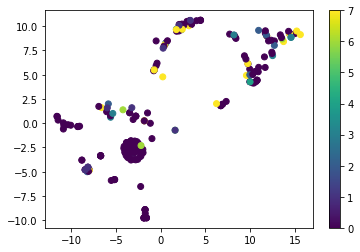

In [ ]:

dropColumn=[]
#dropColumn.extend(['first_success_flg','first_retire_flg','first_fraud_flg','first_start_flg','first_bad_miss_rate','first_live_master_point','first_threed_live_flg','first_easy_success_flg','first_normal_success_flg','first_hard_success_flg','first_expert_success_flg','first_easy_retire_flg','first_normal_retire_flg','first_hard_retire_flg','first_expert_retire_flg','first_solo_flg','first_normal_music_flg','first_cover_music_count'])
dropColumn.extend(['exp','main_story_flg','event_story_flg','character_story_flg','live_master_point','total_point','next_week_login_days','next_day_flg','favorite_master_card_id','master_character_id','Unnamed: 0_x','Unnamed: 0_y'])
df_dropped=dfDropColumn(df_tutorial_complete,dropColumn)
#pca=getPCA(df_dropped)
#showCCratio(pca, df_dropped)
#dff=getPcaDataFrame(pca, df_dropped)

df_embedded=getTSNEDataFrameEmbedded(df_dropped)
showTSNEresult(df_embedded, df_tutorial_complete["next_week_login_days"])

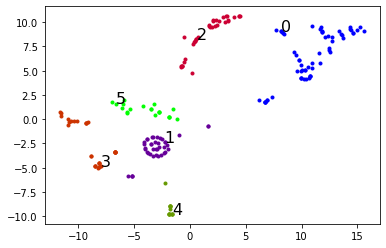

In [ ]:
kmeans_tsne=getKmeansTSNE(df_embedded, 6)

showTSNEClustering(df_embedded, kmeans_tsne)
df_grouped=getGroupedDataFrame(kmeans_tsne, df_dropped)

In [ ]:
#個数と平均をまとめて出力
def showAllCountAndMean(df, groupCount):
  #空のDataFrameを定義
  df_count_and_means=pd.DataFrame(index=[], columns=df.columns)
  for i in range(groupCount):
    #groupの数分countとmeanを出力
    df_count_and_means=df_count_and_means.append(showGroupDescribe(df, 'group_' + str(i))['count':'mean'])
  return df_count_and_means

showAllCountAndMean(df_grouped, 6)

KeyError: ignored

In [ ]:
df_grouped=joinResetIndex(df_grouped, df_tutorial_complete['next_week_login_days'])
df_grouped=joinResetIndex(df_grouped, df_tutorial_complete['next_day_flg'])
df_grouped=joinResetIndex(df_grouped, df_tutorial_complete['user_id'])
df_grouped=joinResetIndex(df_grouped, df_tutorial_complete['master_character_id'])
df_grouped=joinResetIndex(df_grouped, df_tutorial_complete['favorite_master_card_id'])
#df_grouped=joinResetIndex(df_grouped, df_tutorial_complete['creation_day'])
showAllCountAndMean(df_grouped, 6)

,group_0,group_1,group_2,group_3,group_4,group_5,group,get_gift_item_flg,lottery_count,price_total,use_charge_gem_count_sum,use_free_gem_count_sum,use_item_count_sum,live_count,multi_live_count,normal_music_count,event_music_count,cover_music_count,original_music_count,this_event_music_count,live_flg,live_music_kind_count,easy_success_count,normal_success_count,hard_success_count,expert_success_count,tutorial_progress,not_received_mission_reward_count,receive_mission_reward_count,daily_mission_count,weekly_mission_count,beginner_mission_count,twitter_follow_count,line_follow_count,rarity4_flg,special_event_card_flg,mission_progress_sum,first_success_flg,first_retire_flg,first_fraud_flg,first_start_flg,first_bad_miss_rate,first_live_master_point,first_threed_live_flg,first_easy_success_flg,first_normal_success_flg,first_hard_success_flg,first_expert_success_flg,first_easy_retire_flg,first_normal_retire_flg,first_hard_retire_flg,first_expert_retire_flg,first_solo_flg,first_normal_music_flg,first_cover_music_count,event_story_progress,main_story_progress,character_story_progress,nurturing_card_count,get_item_type_practice_ticket_sum,get_item_type_skill_practice_ticket_sum,use_item_type_practice_ticket_flg,use_item_type_skill_practice_ticket_flg,costume_count,costume_model_count,profile_setting_count,next_week_login_days,next_day_flg,user_id,master_character_id,favorite_master_card_id
count,63.0,63.0,63.0,63.0,63.0,63.0,63.0,63.000000,63.000000,63.000000,63.000000,63.000000,63.000000,63.000000,63.000000,63.000000,63.000000,63.000000,63.000000,63.0,63.000000,63.000000,63.000000,63.000000,63.000000,63.000000,63.0,63.0,63.000000,63.000000,63.0,63.000000,63.000000,63.000000,63.000000,63.0,63.000000,63.000000,63.000000,63.0,63.000000,63.000000,63.000000,63.000000,63.000000,63.000000,63.000000,63.000000,63.000000,63.000,63.000000,63.000000,63.000000,63.000000,63.000000,63.000000,63.000000,63.000000,63.000000,63.000000,63.000000,63.000000,63.000000,63.000000,63.000000,63.000000,63.000000,63.000000,6.300000e+01,6.300000e+01,6.300000e+01
mean,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.984127,3.000000,175.079365,89.047619,4406.984127,0.015873,13.460317,3.142857,58.492063,0.904762,32.650794,25.841270,0.0,0.857143,7.650794,11.714286,11.904762,13.095238,16.412698,70.0,0.0,20.253968,0.206349,0.0,0.015873,0.047619,0.047619,0.539683,0.0,8.698413,0.714286,0.126984,0.0,0.015873,0.014679,1279.380952,0.015873,0.253968,0.095238,0.126984,0.222222,0.031746,0.000,0.031746,0.047619,0.857143,0.857143,0.285714,4.301587,4.015873,9.492063,1.444444,18.301587,2.047619,0.539683,0.238095,0.507937,0.507937,13.666667,1.380952,0.507937,1.010315e+13,1.055873e+07,1.059064e+07
count,40.0,40.0,40.0,40.0,40.0,40.0,40.0,40.000000,40.000000,40.000000,40.000000,40.000000,40.000000,40.000000,40.000000,40.000000,40.000000,40.000000,40.000000,40.0,40.000000,40.000000,40.000000,40.000000,40.000000,40.000000,40.0,40.0,40.000000,40.000000,40.0,40.000000,40.000000,40.000000,40.000000,40.0,40.000000,40.000000,40.000000,40.0,40.000000,40.000000,40.000000,40.000000,40.000000,40.000000,40.000000,40.000000,40.000000,40.000,40.000000,40.000000,40.000000,40.000000,40.000000,40.000000,40.000000,40.000000,40.000000,40.000000,40.000000,40.000000,40.000000,40.000000,40.000000,40.000000,40.000000,40.000000,4.000000e+01,4.000000e+01,4.000000e+01
mean,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.000000,0.050000,0.000000,0.000000,12.500000,0.000000,0.250000,0.000000,1.150000,0.000000,0.950000,0.200000,0.0,0.150000,0.225000,0.100000,0.000000,0.000000,0.100000,70.0,0.0,0.050000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.125000,0.0,0.025000,0.000000,0.000000,0.025000,0.000000,0.000000,0.000000,0.000000,0.000000,0.025,0.025000,0.025000,0.150000,0.150000,0.125000,0.050000,0.000000,0.275000,0.000000,1.150000,0.175000,0.000000,0.000000,0.000000,0.000000,14.000000,0.375000,0.325000,1.010467e+13,1.055750e+07,1.058775e+07
count,36.0,36.0,36.0,36.0,36.0,36.0,36.0,36.000000,36.000000,36.000000,36.000000,3

In [ ]:

df_grouped=mergeDataFrame(df_grouped, df_item_get_data, 'user_id', 'user_id')


In [ ]:


df_grouped

,group_0,group_1,group_2,group_3,group_4,group_5,group,get_gift_item_flg_x,lottery_count,price_total,use_charge_gem_count_sum,use_free_gem_count_sum,use_item_count_sum,live_count,multi_live_count,normal_music_count,event_music_count,cover_music_count,original_music_count,this_event_music_count,live_flg,live_music_kind_count,easy_success_count,normal_success_count,hard_success_count,expert_success_count,tutorial_progress,not_received_mission_reward_count,receive_mission_reward_count,daily_mission_count,weekly_mission_count,beginner_mission_count,twitter_follow_count,line_follow_count,rarity4_flg,special_event_card_flg,mission_progress_sum,event_story_progress,main_story_progress,character_story_progress,nurturing_card_count,get_item_type_practice_ticket_sum,get_item_type_skill_practice_ticket_sum,use_item_type_practice_ticket_flg,use_item_type_skill_practice_ticket_flg,costume_count,costume_model_count,profile_setting_count,next_week_login_days,next_day_flg,user_id,master_character_id,favorite_master_card_id,get_gift_item_flg_y
0,0,1,0,0,0,0,1,1.0,1.0,0.0,0.0,2500.0,0.0,1.0,0.0,5.0,0.0,5.0,0.0,0.0,1.0,1.0,0.0,0.0,5.0,0.0,70.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,222.0,6.0,0.0,3.0,4.0,8.0,2.0,0.0,0.0,0.0,0.0,14,0.0,1.0,9094706508156,10600000,10640002,1.0
1,1,0,0,0,0,0,0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,70.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,461.0,7.0,0.0,72.0,12.0,0.0,0.0,0.0,0.0,0.0,0.0,11,7.0,1.0,9083002805556,10400000,10440001,0.0
2,0,0,0,1,0,0,3,1.0,0.0,0.0,0.0,0.0,0.0,8.0,0.0,37.0,0.0,37.0,0.0,0.0,1.0,7.0,0.0,0.0,28.0,9.0,70.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,183.0,7.0,15.0,41.0,5.0,13.0,3.0,1.0,0.0,0.0,1.0,14,0.0,1.0,9074234202559,10300000,10340001,1.0
3,0,0,1,0,0,0,2,1.0,4.0,4900.0,4325.0,3235.0,0.0,3.0,0.0,14.0,0.0,5.0,9.0,0.0,1.0,3.0,0.0,0.0,14.0,0.0,70.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,648.0,33.0,20.0,0.0,47.0,8.0,2.0,1.0,0.0,0.0,1.0,8,7.0,1.0,9071498402251,10500000,10540003,1.0
4,1,0,0,0,0,0,0,1.0,1.0,0.0,60.0,0.0,0.0,20.0,0.0,69.0,19.0,23.0,46.0,0.0,1.0,19.0,0.0,0.0,24.0,60.0,70.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,463.0,32.0,13.0,7.0,40.0,25.0,3.0,0.0,0.0,0.0,1.0,14,7.0,1.0,9072844505059,10500000,10530001,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3308,0,0,0,0,1,0,4,1.0,0.0,0.0,0.0,0.0,0.0,25.0,0.0,92.0,8.0,0.0,92.0,0.0,1.0,3.0,8.0,12.0,56.0,24.0,70.0,0.0,26.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,42.0,6.0,0.0,0.0,0.0,31.0,3.0,0.0,0.0,0.0,1.0,14,0.0,1.0,10073921200598,10500000,10530001,1.0
3309,0,0,1,0,0,0,2,1.0,5.0,1840.0,1340.0,11160.0,0.0,54.0,0.0,208.0,40.0,157.0,51.0,0.0,1.0,13.0,9.0,9.0,9.0,206.0,70.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,934.0,38.0,0.0,110.0,51.0,62.0,4.0,1.0,0.0,0.0,1.0,14,7.0,1.0,9186349500151,10300000,10330003,1.0
3310,0,0,0,0,0,1,5,1.0,5.0,0.0,0.0,5500.0,1.0,15.0,0.0,67.0,0.0,59.0,8.0,0.0,1.0,9.0,0.0,0.0,19.0,36.0,70.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1055.0,34.0,20.0,0.0,38.0,20.0,4.0,1.0,1.0,0.0,1.0,13,3.0,0.0,9134518109953,10900000,10930003,1.0
3311,1,0,0,0,0,0,0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,5.0,0.0,5.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,70.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,750.0,18.0,20.0,2.0,7.0,1.0,1.0,0.0,0.0,0.0,1.0,14,2.0,0.0,9074232401659,10900000,10940001,1.0


In [ ]:
def showHeatmap(df):
  colormap = plt.cm.RdBu
  plt.figure(figsize=(14,12))
  plt.title('Pearson Correlation of Features', y=1.05, size=15)
  sns.heatmap(df.astype(float).corr(),linewidths=0.1,vmax=1.0, 
            square=True, cmap=colormap, linecolor='white', annot=True)

In [ ]:
df_test=dfDropColumn(df_tutorial_complete,['exp','main_story_flg','event_story_flg','character_story_flg','favorite_master_card_id','master_character_id','Unnamed: 0.1'])

df_test.corr().to_csv('test.csv')

In [ ]:
def showHistograms(df, group_count, column):
    for i in range(group_count):
        showHistogram(getFilterdGroup(df, 'group_' + str(i))[column])
  

In [ ]:
df_grouped

,group_0,group_1,group_2,group_3,group_4,group_5,group,get_gift_item_flg,lottery_count,price_total,use_charge_gem_count_sum,use_free_gem_count_sum,use_item_count_sum,live_count,multi_live_count,normal_music_count,event_music_count,cover_music_count,original_music_count,this_event_music_count,live_flg,live_music_kind_count,easy_success_count,normal_success_count,hard_success_count,expert_success_count,tutorial_progress,not_received_mission_reward_count,receive_mission_reward_count,daily_mission_count,weekly_mission_count,beginner_mission_count,twitter_follow_count,line_follow_count,rarity4_flg,special_event_card_flg,mission_progress_sum,event_story_progress,main_story_progress,character_story_progress,nurturing_card_count,get_item_type_practice_ticket_sum,get_item_type_skill_practice_ticket_sum,use_item_type_practice_ticket_flg,use_item_type_skill_practice_ticket_flg,costume_count,costume_model_count,profile_setting_count,next_week_login_days,next_day_flg,user_id,master_character_id,favorite_master_card_id
0,0,0,1,0,0,0,2,1.0,2.0,0.0,0.0,5000.0,0.0,48.0,37.0,193.0,0.0,104.0,89.0,0.0,1.0,9.0,12.0,12.0,60.0,57.0,70.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,293.0,3.0,0.0,0.0,33.0,37.0,4.0,1.0,1.0,1.0,1.0,11,7.0,1.0,9073145808857,11000000,11040002
1,0,0,0,0,0,1,5,1.0,0.0,0.0,0.0,0.0,0.0,31.0,0.0,104.0,20.0,80.0,24.0,0.0,1.0,8.0,0.0,24.0,92.0,8.0,70.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,164.0,7.0,0.0,0.0,23.0,33.0,1.0,1.0,1.0,0.0,0.0,14,7.0,1.0,9073225608151,10600000,10640001
2,0,0,0,0,1,0,4,1.0,1.0,0.0,0.0,2500.0,0.0,27.0,0.0,64.0,44.0,48.0,16.0,0.0,1.0,8.0,32.0,32.0,44.0,0.0,70.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,180.0,7.0,0.0,0.0,37.0,30.0,2.0,1.0,1.0,0.0,0.0,14,7.0,1.0,9076819802359,10500000,10530001
3,0,1,0,0,0,0,1,1.0,0.0,0.0,0.0,0.0,0.0,27.0,83.0,91.0,20.0,53.0,38.0,0.0,1.0,23.0,20.0,20.0,13.0,54.0,70.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,216.0,1.0,0.0,0.0,9.0,30.0,2.0,1.0,1.0,1.0,1.0,14,7.0,1.0,9071294108457,10800000,10830001
4,0,0,1,0,0,0,2,1.0,2.0,0.0,0.0,5000.0,0.0,62.0,0.0,196.0,52.0,160.0,36.0,0.0,1.0,9.0,12.0,12.0,116.0,88.0,70.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,308.0,7.0,0.0,23.0,17.0,61.0,2.0,1.0,1.0,0.0,0.0,9,7.0,1.0,9071228802956,10400000,10430001
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4631,1,0,0,0,0,0,0,1.0,3.0,0.0,0.0,7500.0,0.0,29.0,5.0,118.0,0.0,16.0,102.0,0.0,1.0,8.0,0.0,0.0,0.0,113.0,70.0,0.0,6.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,220.0,1.0,0.0,2.0,9.0,31.0,2.0,1.0,1.0,1.0,1.0,14,7.0,1.0,9167002909856,10700000,10740002
4632,0,0,1,0,0,0,2,1.0,2.0,0.0,0.0,5000.0,0.0,27.0,0.0,84.0,24.0,56.0,28.0,0.0,1.0,11.0,108.0,0.0,0.0,0.0,70.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,129.0,7.0,0.0,0.0,39.0,31.0,2.0,1.0,1.0,0.0,0.0,5,7.0,1.0,9075998807655,10200000,10230002
4633,0,0,0,0,1,0,4,1.0,2.0,0.0,0.0,2750.0,0.0,28.0,0.0,81.0,32.0,28.0,53.0,0.0,1.0,15.0,12.0,40.0,41.0,16.0,70.0,0.0,3.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,155.0,8.0,0.0,2.0,38.0,31.0,2.0,1.0,1.0,1.0,1.0,10,7.0,1.0,9072573403059,10100000,10140003
4634,0,0,1,0,0,0,2,1.0,2.0,0.0,0.0,5000.0,0.0,26.0,0.0,94.0,12.0,40.0,54.0,0.0,1.0,15.0,28.0,78.0,0.0,0.0,70.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,126.0,4.0,0.0,0.0,19.0,31.0,2.0,1.0,1.0,0.0,0.0,14,6.0,1.0,9071299505056,10500000,10530001


In [ ]:
getFilterdGroup(df_grouped, 'group_0')['price_total'].to_csv('mahouka_kakin.csv')

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


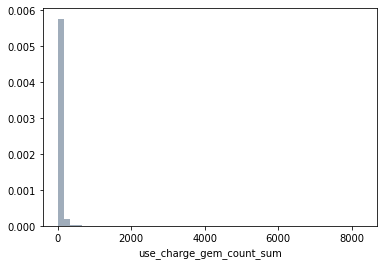

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


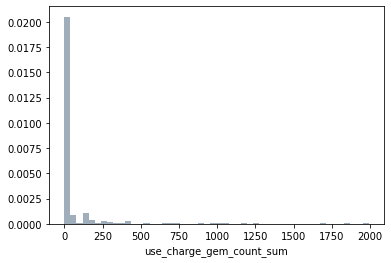

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


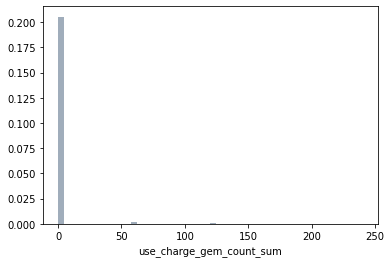

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


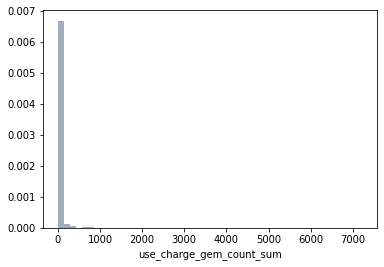

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


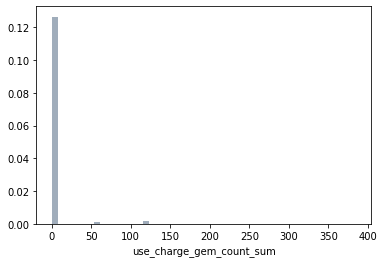

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


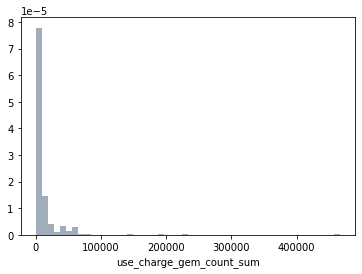

0.0     851
1.0      15
2.0       5
5.0       2
3.0       1
11.0      1
9.0       1
Name: main_story_progress, dtype: int64

In [ ]:
showHistograms(df_grouped, 6, 'use_charge_gem_count_sum')
getFilterdGroup(df_grouped, 'group_2')['main_story_progress'].value_counts()

In [ ]:
df_ux_flow_with_nextdayweek_na=pd.read_csv("/content/drive/My Drive/df_ux_flow_fixed_20201022.csv")

#翌週訪問フラグ
df_ux_flow_with_nextdayweek_na.loc[df_ux_flow_with_nextdayweek_na['next_week_login_days'] > 0, 'next_week_login_flg']=1
df_ux_flow_with_nextdayweek_na.loc[df_ux_flow_with_nextdayweek_na['next_week_login_days'] == 0, 'next_week_login_flg']=0

#ライブフラグ
df_ux_flow_with_nextdayweek_na.loc[df_ux_flow_with_nextdayweek_na['live_count'] > 0, 'live_flg']=1
df_ux_flow_with_nextdayweek_na.loc[df_ux_flow_with_nextdayweek_na['live_count'] == 0, 'live_flg']=0

#ガチャフラグ
#df_ux_flow_with_nextdayweek_na.loc[df_ux_flow_with_nextdayweek_na['lottery_count'] > 0, 'lottery_flg']=1
#df_ux_flow_with_nextdayweek_na.loc[df_ux_flow_with_nextdayweek_na['lottery_count'] == 0, 'lottery_flg']=0

#expのミスを修正
df_ux_flow_with_nextdayweek_na.loc[df_ux_flow_with_nextdayweek_na['card_exp_sum'] <= 50, 'card_exp_sum_flg']=0
df_ux_flow_with_nextdayweek_na.loc[df_ux_flow_with_nextdayweek_na['card_exp_sum'] > 50, 'card_exp_sum_flg']=1

df_ux_flow_with_nextdayweek_na.loc[df_ux_flow_with_nextdayweek_na['card_exp_avg'] <= 10, 'card_exp_avg_flg']=0
df_ux_flow_with_nextdayweek_na.loc[df_ux_flow_with_nextdayweek_na['card_exp_avg'] > 10, 'card_exp_avg_flg']=1

#df_risemara_first1000=df_ux_flow_with_nextdayweek_na.query('(lottery_count == 4 & price_total == 0 & live_count== 0 & nurturing_card_count==0' )
#df_risemara_character_story=df_ux_flow_with_nextweek_na.query('(lottery_count == 8 & character_story_progress > 0 & price_total == 0 & live_count== 0 & nurturing_card_count==0' )


df_not_leave=df_ux_flow_with_nextdayweek_na.query('(next_week_login_flg==1)')
#ライブして離脱していない人(全体)
#df_live_not_leave=df_ux_flow_with_nextdayweek_na.query('(live_count > 0 & next_week_login_flg==1)')

#ライブしてないで離脱した人(全体)
#df_not_live_do_leave=df_ux_flow_with_nextdayweek_na.query('(live_count == 0 & next_week_login_flg==0)')
#df_not_live_do_nextdayweek_leave=df_ux_flow_with_nextdayweek_na.query('(live_count == 0 & next_day_flg==0 & next_week_login_flg==0)')

#リセマラ
#df_risemara=df_ux_flow_with_nextdayweek_na.query('(live_count == 0 & next_day_flg==0 & next_week_login_flg==0 & character_story_progress==11 & nurturing_card_count==0)')
df_not_risemara=df_ux_flow_with_nextdayweek_na.query('(live_count > 0 | next_day_flg > 0 | next_week_login_flg > 0 | nurturing_card_count > 0 | lottery_count==0)')
df_not_risemara_modify=df_ux_flow_with_nextdayweek_na.query('(live_count > 0 | next_day_flg > 0 | next_week_login_flg > 0 | nurturing_card_count > 0 | lottery_count==0 | character_story_progress != 11)')

df_live_tutorial_clear=df_not_risemara.query('(tutorial_progress==70)')

#ライブして離脱していない人(リセマラ以外)
df_live_not_leave=df_not_risemara.query('(live_count > 0 & next_week_login_flg==1)')
#5回以下ライブして離脱していない人(リセマラ以外)
df_live_not_leave_under_live5=df_not_risemara.query('(live_count > 0 & live_count <= 5 & next_week_login_flg==1)')

#ライブしてないで離脱した人(リセマラ以外) チュートリアル終わってない人が大半だったので終わっている人に絞りたい
df_not_live=df_not_risemara.query('(live_count == 0)')
df_not_live_do_leave=df_not_risemara.query('(live_count == 0 & next_week_login_flg==0)')
df_not_live_do_nextday_leave=df_not_risemara.query('(live_count == 0 & next_day_flg==0)')
df_not_live_do_nextdayweek_leave=df_not_risemara.query('(live_count == 0 & next_day_flg==0 & next_week_login_flg==0 )')

#☆4ゲット勢
df_rarity4_flg=df_not_risemara.query('(rarity4_flg > 0)')
df_rarity4_all_flg=df_ux_flow_with_nextdayweek_na.query('(rarity4_flg > 0)')


#初回成功
df_not_risemara_success=df_not_risemara.query('first_easy_success_flg==1 | first_normal_success_flg==1 | first_hard_success_flg==1 | first_expert_success_flg==1')
#初回失敗
df_not_risemara_retire=df_not_risemara.query('first_easy_retire_flg==1 | first_normal_retire_flg==1 | first_hard_retire_flg==1 | first_expert_retire_flg==1')

In [ ]:
#df_ux_flow_with_nextweek_na[df_ux_flow_with_nextweek_na['live_count'] <1].corr()
#翌週訪問フラグ
df_ux_flow_with_nextweek_na.loc[df_ux_flow_with_nextweek_na['next_week_login_days'] > 0, 'next_week_login_flg']=1
df_ux_flow_with_nextweek_na.loc[df_ux_flow_with_nextweek_na['next_week_login_days'] == 0, 'next_week_login_flg']=0

#ガチャフラグ
df_ux_flow_with_nextweek_na.loc[df_ux_flow_with_nextweek_na['lottery_count'] > 0, 'lottery_flg']=1
df_ux_flow_with_nextweek_na.loc[df_ux_flow_with_nextweek_na['lottery_count'] == 0, 'lottery_flg']=0

#リセマラ
df_risemara=df_ux_flow_with_nextweek_na.query('live_count < 1 & lottery_count == 4 & price_total == 0 & live_count==0' )
df_not_risemara=df_ux_flow_with_nextweek_na.query('live_count >= 1 | lottery_count != 4 | price_total > 0 | live_count > 0' )
df_not_risemara_live0=df_not_risemara.query('live_count == 0' )

df_not_risemara_live0=df_not_risemara.query('live_count == 0')

#翌日非ログイン
df_not_login_next_day=df_ux_flow_with_nextweek_na[df_ux_flow_with_nextweek_na['next_day_flg']==0]
df_login_next_day=df_ux_flow_with_nextweek_na[df_ux_flow_with_nextweek_na['next_day_flg']>0]

#翌週非ログイン
df_not_login_next_week=df_ux_flow_with_nextweek_na[df_ux_flow_with_nextweek_na['next_week_login_flg']==0]
df_not_login_next_week_live=df_not_login_next_week[df_not_login_next_week['live_count']>0]
df_not_login_next_week_live0=df_not_login_next_week[df_not_login_next_week['live_count']==0]
#初回成功
df_not_risemara_success=df_ux_flow_with_nextweek_na.query('first_easy_success_flg==1 | first_normal_success_flg==1 | first_hard_success_flg==1 | first_expert_success_flg==1')
#初回失敗
df_not_risemara_retire=df_ux_flow_with_nextweek_na.query('first_easy_retire_flg==1 | first_normal_retire_flg==1 | first_hard_retire_flg==1 | first_expert_retire_flg==1')



In [ ]:
df_ux_flow_with_nextdayweek_na=pd.read_csv("/content/drive/My Drive/df_ux_flow_fixed_20201025.csv")
df_tutorial_complete=df_ux_flow_with_nextdayweek_na[df_ux_flow_with_nextdayweek_na['tutorial_progress'] > 0]
df_dropped=dfDropColumn(df_tutorial_complete)
pca=getPCA(df_dropped)

#showCCratio(pca, df_dropped)
dff=getPcaDataFrame(pca, df_dropped)


tsne = TSNE(n_components=2, random_state = 0, perplexity = 30, n_iter = 1000)
df_dropped2_embedded = tsne.fit_transform(df_dropped2)

plt.scatter(df_dropped2_embedded[:, 0], df_dropped2_embedded[:, 1], c=df_except_tutorial0["next_week_login_days"])
plt.colorbar()

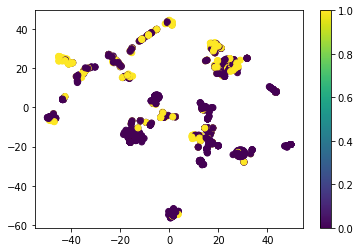

In [ ]:
#df_dropped=joinDummies(df_dropped, df_tutorial_complete['master_character_id'], 'character')

df_embedded=getTSNEDataFrameEmbedded(df_dropped)
showTSNEresult(df_embedded, df_tutorial_complete["next_day_flg"])

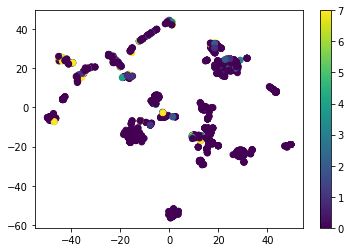

In [ ]:
showTSNEresult(df_embedded, df_tutorial_complete["next_week_login_days"])

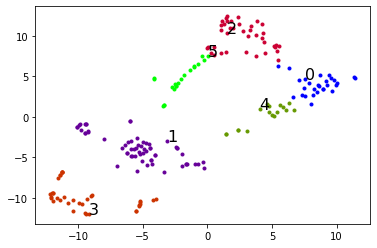

In [ ]:
kmeans_tsne=getKmeansTSNE(df_embedded, 6)

showTSNEClustering(df_embedded, kmeans_tsne)
df_grouped=getGroupedDataFrame(kmeans_tsne, df_dropped)
df_grouped.to_csv("/content/drive/My Drive/grouped_new_user20201025.csv")

In [ ]:
df_grouped

,group_0,group_1,group_2,group_3,group_4,group_5,group,get_gift_item_flg,lottery_count,price_total,use_charge_gem_count_sum,use_free_gem_count_sum,use_item_count_sum,live_count,multi_live_count,normal_music_count,event_music_count,cover_music_count,original_music_count,this_event_music_count,live_flg,live_music_kind_count,easy_success_count,normal_success_count,hard_success_count,expert_success_count,tutorial_progress,not_received_mission_reward_count,receive_mission_reward_count,daily_mission_count,weekly_mission_count,beginner_mission_count,twitter_follow_count,line_follow_count,rarity4_flg,special_event_card_flg,mission_progress_sum,first_success_flg,first_retire_flg,first_fraud_flg,first_start_flg,first_bad_miss_rate,first_live_master_point,first_threed_live_flg,first_easy_success_flg,first_normal_success_flg,first_hard_success_flg,first_expert_success_flg,first_easy_retire_flg,first_normal_retire_flg,first_hard_retire_flg,first_expert_retire_flg,first_solo_flg,first_normal_music_flg,first_cover_music_count,event_story_progress,main_story_progress,character_story_progress,nurturing_card_count,get_item_type_practice_ticket_sum,get_item_type_skill_practice_ticket_sum,use_item_type_practice_ticket_flg,use_item_type_skill_practice_ticket_flg,costume_count,costume_model_count,profile_setting_count,Unnamed: 0_x,Unnamed: 0_y
0,0,0,0,1,0,0,3,1.0,1.0,0.0,0.0,2500.0,0.0,3.0,0.0,13.0,0.0,5.0,8.0,0.0,1.0,2.0,0.0,0.0,9.0,4.0,70.0,0.0,10.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,1.0,0.0,0.0,0.0,0.047619,3624.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,2.0,10.0,0.0,6.0,1.0,0.0,0.0,0.0,0.0,14,0.0,0.0
1,0,0,0,0,1,0,4,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,5.0,0.0,0.0,5.0,0.0,1.0,1.0,0.0,5.0,0.0,0.0,70.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,1.0,0.0,0.0,0.0,0.015625,1243.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,3.0,1.0,0.0,0.0,0.0,0.0,14,5010.0,6146.0
2,0,0,1,0,0,0,2,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,70.0,0.0,25.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,1.0,0.0,0.0,1.0,1.0,12,37697.0,4338.0
3,0,0,0,1,0,0,3,1.0,0.0,0.0,0.0,0.0,0.0,4.0,0.0,17.0,0.0,0.0,17.0,0.0,1.0,4.0,0.0,0.0,0.0,17.0,70.0,0.0,17.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,11.0,1.0,0.0,0.0,0.0,0.035714,3100.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,3.0,3.0,11.0,0.0,7.0,2.0,0.0,0.0,0.0,0.0,14,0.0,0.0
4,0,0,1,0,0,0,2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,70.0,0.0,4.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,14,24848.0,8351.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
199,0,0,0,1,0,0,3,1.0,1.0,0.0,0.0,2500.0,0.0,1.0,0.0,5.0,0.0,0.0,5.0,0.0,1.0,1.0,5.0,0.0,0.0,0.0,70.0,0.0,12.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,3.0,1.0,0.0,0.0,0.0,0.000000,394.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,11.0,0.0,4.0,2.0,0.0,0.0,1.0,1.0,14,0.0,0.0
200,0,0,1,0,0,0,2,1.0,4.0,0.0,0.0,1000.0,0.0,42.0,0.0,182.0,0.0,101.0,81.0,0.0,1.0,23.0,80.0,44.0,27.0,8.0,70.0,0.0,41.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.010417,471.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,1.0,4.0,6.0,7.0,2.0,48.0,3.0,1.0,1.0,1.0,1.0,14,41014.0,27965.0
201,0,0,1,0,0,0,2,1.0,1.0,0.0,0.0,2500.0,0.0,7.0,0.0,31.0,0.0,10.0,21.0,0.0,1.0,7.0,0.0,0.0,0.0,31.0,70.0,0.0,45.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,17.0,1.0,0.0,0.0,0.0,0.015444,3746.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,2.0,2.0,0.0,1.0,14.0,1.0,1.0,0.0,1.0,1.0,5,26152.0,30225.0
202,0,1,0,0,0,0,1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,10.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.000

In [ ]:
df_grouped=joinResetIndex(df_grouped, df_tutorial_complete['next_week_login_days'])
df_grouped=joinResetIndex(df_grouped, df_tutorial_complete['next_day_flg'])
df_grouped=joinResetIndex(df_grouped, df_tutorial_complete['user_id'])
df_grouped=joinResetIndex(df_grouped, df_tutorial_complete['master_character_id'])
df_grouped=joinResetIndex(df_grouped, df_tutorial_complete['favorite_master_card_id'])
showAllCountAndMean(df_grouped, 6)

df_grouped.to_csv('/content/drive/My Drive/grouped_new_user20201025_with_user_id.csv')


ValueError: ignored

In [ ]:
df_grouped=joinDummies(df_grouped, df_grouped['master_character_id'], 'character')

In [ ]:
df_grouped6['master_character_id'].value_counts()

10700000    250
10300000    229
10600000    224
10400000    171
10500000    151
10900000    137
10200000    130
10800000     93
11000000     63
11100000     60
10100000     43
0             1
Name: master_character_id, dtype: int64

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


1.0    17
0.0     3
Name: rarity4_flg, dtype: int64

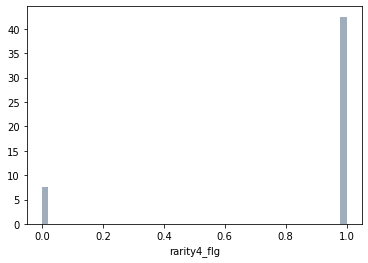

In [ ]:
#showHistogram(getFilterdGroup(df_grouped, 'group_2')['normal_success_count'])
#getFilterdGroup(df_grouped, 'group_2')['normal_success_count'].value_counts()
showHistogram(getFilterdGroup(df_grouped, 'group_4')['rarity4_flg'])
getFilterdGroup(df_grouped, 'group_4')['rarity4_flg'].value_counts()

In [ ]:
#showHistogram(getFilterdGroup(df_grouped, 'group_2')['special_event_card_flg'])
#showHistogram(getFilterdGroup(df_grouped, 'group_4')['special_event_card_flg'])


#countMatchingValue(getFilterdGroup(df_grouped, 'group_2'), 'nurturing_card_count', 0) 
countMatchingValue(getFilterdGroup(df_grouped, 'group_4'), 'nurturing_card_count', 0) 


141

/usr/local/lib/python3.6/dist-packages/seaborn/distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


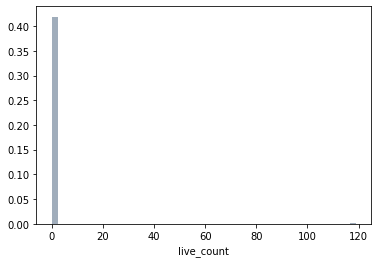

In [ ]:
#showHistogram(getFilterdGroup(df_grouped, 'group_2')['multi_live_count'])
showHistogram(getFilterdGroup(df_grouped, 'group_5')['live_count'])

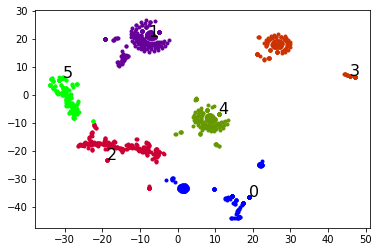

In [ ]:
from sklearn.cluster import MiniBatchKMeans
import matplotlib.cm as cm
# クラスタの数`n_clusters`はTSNEのグラフを見て、感覚で決めた
kmeans = MiniBatchKMeans(n_clusters=6, max_iter=300)
kmeans_tsne = kmeans.fit_predict(df_dropped2_embedded)

#いい感じに色を付ける
color=cm.brg(np.linspace(0,1,np.max(kmeans_tsne) - np.min(kmeans_tsne)+1))
for i in range(np.min(kmeans_tsne), np.max(kmeans_tsne)+1):
    plt.plot(df_dropped2_embedded[kmeans_tsne == i][:,0],
             df_dropped2_embedded[kmeans_tsne == i][:,1],
             ".",
             color=color[i]
             )
    plt.text(df_dropped2_embedded[kmeans_tsne == i][:,0][0],
             df_dropped2_embedded[kmeans_tsne == i][:,1][0],
             str(i), color="black", size=16
             )

In [ ]:
getGroupDescribe(df_result_group_modified, 'GROUP_5')

,GROUP_0,GROUP_1,GROUP_2,GROUP_3,GROUP_4,GROUP_5,group,get_gift_item_flg,lottery_count,live_count,multi_live_count,live_music_kind_count,tutorial_progress,rarity4_flg,special_event_card_flg,first_success_flg,first_retire_flg,first_start_flg,first_bad_miss_rate,first_threed_live_flg,event_story_progress,main_story_progress,character_story_progress,nurturing_card_count,use_item_type_practice_ticket_flg,use_item_type_skill_practice_ticket_flg
count,188.0,188.0,188.0,188.0,188.0,188.0,188.0,161.0,161.000000,161.000000,161.000000,161.000000,161.000000,161.000000,161.000000,161.000000,161.000000,161.000000,161.000000,161.0,161.000000,161.000000,161.000000,161.000000,161.000000,161.000000
mean,0.0,0.0,0.0,0.0,0.0,1.0,5.0,1.0,1.857143,2.273292,0.155280,1.459627,68.322981,0.105590,0.062112,0.180124,0.068323,0.012422,0.004038,0.0,0.888199,0.857143,6.465839,0.142857,0.093168,0.049689
std,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.999554,7.537396,1.015868,4.266137,9.633018,0.308271,0.242112,0.385490,0.253087,0.111107,0.014280,0.0,3.276801,2.260689,6.602112,0.557418,0.291574,0.217981
min,0.0,0.0,0.0,0.0,0.0,1.0,5.0,1.0,0.000000,0.000000,0.000000,0.000000,10.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.0,0.0,0.0,0.0,0.0,1.0,5.0,1.0,0.000000,0.000000,0.000000,0.000000,70.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.0,0.0,0.0,0.0,0.0,1.0,5.0,1.0,1.000000,0.000000,0.000000,0.000000,70.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,11.000000,0.000000,0.000000,0.000000
75%,0.0,0.0,0.0,0.0,0.0,1.0,5.0,1.0,3.000000,2.000000,0.000000,1.000000,70.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,1.000000,0.000000,11.000000,0.000000,0.000000,0.000000
max,0.0,0.0,0.0,0.0,0.0,1.0,5.0,1.0,11.000000,78.000000,8.000000,45.000000,70.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.113402,0.0,35.000000,20.000000,39.000000,4.000000,1.000000,1.000000


In [ ]:
getGroupDescribe(df_result_group_modified, 'GROUP_3')

,GROUP_0,GROUP_1,GROUP_2,GROUP_3,GROUP_4,GROUP_5,group,get_gift_item_flg,lottery_count,live_count,multi_live_count,live_music_kind_count,tutorial_progress,rarity4_flg,special_event_card_flg,first_success_flg,first_retire_flg,first_start_flg,first_bad_miss_rate,first_threed_live_flg,event_story_progress,main_story_progress,character_story_progress,nurturing_card_count,use_item_type_practice_ticket_flg,use_item_type_skill_practice_ticket_flg
count,211.0,211.0,211.0,211.0,211.0,211.0,211.0,183.0,183.000000,183.000000,183.000000,183.000000,183.000000,183.000000,183.000000,183.000000,183.000000,183.000000,183.000000,183.000000,183.000000,183.000000,183.000000,183.000000,183.000000,183.000000
mean,0.0,0.0,0.0,1.0,0.0,0.0,3.0,1.0,2.185792,4.803279,1.366120,2.437158,68.087432,0.114754,0.054645,0.218579,0.060109,0.010929,0.004129,0.005464,0.617486,1.158470,6.218579,0.306011,0.142077,0.071038
std,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,2.056460,17.063379,7.291599,6.836805,9.730038,0.319599,0.227909,0.414416,0.238341,0.104254,0.013142,0.073922,1.762279,3.657301,8.065411,1.055762,0.350086,0.257593
min,0.0,0.0,0.0,1.0,0.0,0.0,3.0,1.0,0.000000,0.000000,0.000000,0.000000,10.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,0.0,0.0,0.0,1.0,0.0,0.0,3.0,1.0,1.000000,0.000000,0.000000,0.000000,70.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
50%,0.0,0.0,0.0,1.0,0.0,0.0,3.0,1.0,1.000000,0.000000,0.000000,0.000000,70.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
75%,0.0,0.0,0.0,1.0,0.0,0.0,3.0,1.0,4.000000,2.000000,0.000000,1.000000,70.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.000000,11.000000,0.000000,0.000000,0.000000
max,0.0,0.0,0.0,1.0,0.0,0.0,3.0,1.0,9.000000,148.000000,54.000000,46.000000,70.000000,1.000000,1.000000,1.000000,1.000000,1.000000,0.097826,1.000000,18.000000,22.000000,46.000000,8.000000,1.000000,1.000000
